What I learned:

14/11/2024:

**Task:** get the crossroads with the most accidents<br>
**Challenge:** ta_crossroads is using multi string for it's crosswalk, crosswalk can be used as a crossroad.<br>
Some crosswalk can be combined to represent a crossroad.

In order to get accidents in a crossroad, we need to turn the crosswalk to a polygon and merge any relating polygon crosswalks together.

**Solution:**
```python
# Convex_hull turns any related group of points to a polygon.
ta_crossroads_['geometry'] = ta_crossroads_.geometry.convex_hull.buffer(10)  # Adjust buffer size

# Combine all geometries into a single multipolygon with merged overlaps
# This step will merge any overlapping polygons into a single geometry
merged_geometry = unary_union(ta_crossroads_.geometry)

# If you want each connected component as a separate polygon, convert the multipolygon back to individual polygons
crossroads_poly = gpd.GeoDataFrame(geometry=[merged_geometry], crs=ta_crossroads_.crs)

# Explode into individual polygons if merged into a MultiPolygon
crossroads_poly = crossroads_poly.explode(index_parts=True).reset_index(drop=True)
```

**Next problem:**<br>
We don't know what the created polygons relate to street wise.<br>
**Idea for a Solution:** use ta_street and ta_crossroads, *sjoin* them and get the names from the merged result 

---- 

16/11/2024

### Problem: Visualizing polygons and count next to them
When visualizing polygons and their related data on a map, it's often necessary to annotate each polygon with additional information. In this case, we want to display the counts of `index_right` (obtained from `i_m_h_ta_mm_crossroads_gdf_.value_counts(subset='index_right')`) above the corresponding polygons. The challenge is to position these annotations clearly without overlapping the polygons.

#### Solution
To solve this:
1. Calculated the counts of `index_right` using `value_counts`.
2. Filtered the polygons from `crossroads_poly` to include only those matching the relevant indices.
3. Used the centroid of each polygon to determine the annotation position, applying a vertical offset to ensure the text is displayed above the polygon.

```python
# Step 1: Get the count of `index_right`
counts = i_m_h_ta_mm_crossroads_gdf_.value_counts(subset='index_right')

# Step 2: Prepare the figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the points and polygons
i_m_h_ta_mm_crossroads_gdf_t10.plot(ax=ax, color='red', marker='o', markersize=1, alpha=0.5, label="Crossroads")
filtered_crossroads = crossroads_poly[crossroads_poly.index.isin(i_m_h_ta_mm_crossroads_gdf_t10.index_right)]
filtered_crossroads.plot(ax=ax, color='black', alpha=0.5, label="Polygons")

# Step 3: Annotate polygons with counts
for idx, row in filtered_crossroads.iterrows():
    count = counts.get(idx, 0)
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y + 0.01,  # Offset to place text above
        str(count), fontsize=10, color="blue", ha='center', va='bottom',
        bbox=dict(facecolor='white', alpha=0.5)
    )

# Display the plot
plt.legend()
plt.show()
```

----

### Problem: Filling Missing Grouped Values in a DataFrame While Preserving Structure

You have a pandas DataFrame containing information about crossroads, including the names of two intersecting streets (`street1_hebrew` and `street2_hebrew`) and a combined `crossroad_name`. In some cases:

1. The `crossroad_name` column contains NaN values.
2. The same crossroad can appear multiple times with the same `index_right` value.
3. The `crossroad_name` values for the same `index_right` may differ or have NaN values.

The goal is to:
- Replace all NaN values in the `crossroad_name` column for a specific `index_right` group with the first non-NaN value from that group.
- Ensure that the DataFrame structure, including `index_right`, remains unchanged.

### Additional Problem

While attempting to solve the problem using `groupby` with the `.apply()` method, the structure of the `index_right` column was altered, leading to issues with the integrity of the DataFrame. Specifically:
- The `index_right` column was modified or removed.
- The alignment of rows in the output was not consistent with the original DataFrame.

#### Solution

To solve the problem while preserving the structure of the DataFrame and the `index_right` column, the following approach was used:

1. Use the `.groupby()` method with the `transform()` function to perform group-wise operations while maintaining the original DataFrame's structure.
2. Within each group, use a lambda function to find the first non-NaN value in the `crossroad_name` column.
3. Assign this value to all rows within the same `index_right` group.
4. Ensure that groups with all NaN values in the `crossroad_name` column remain NaN.

Here’s the implementation:

```python
# Use transform to preserve the structure and avoid changing the index
# Fill each group's NaN values in `crossroad_name` with the first non-NaN value
i_m_h_ta_mm_crossroads_gdf['crossroad_name'] = (
    i_m_h_ta_mm_crossroads_gdf
    .groupby('index_right')['crossroad_name']
    .transform(lambda x: x.dropna().iloc[0] if not x.dropna().empty else None)
)

# View the updated DataFrame
i_m_h_ta_mm_crossroads_gdf
```

-----

### Problem: Counting the number of unique values for each index_right

This check was needed to see if changing the names of the crossroad_name worked properly
#### Solution:
```python
unique_counts = (
    i_m_h_ta_mm_crossroads_gdf.groupby('index_right')
    .agg(
        unique_street1_hebrew=('street1_hebrew', lambda x: x.nunique(dropna=True)),
        unique_street2_hebrew=('street2_hebrew', lambda x: x.nunique(dropna=True))
    )
    .reset_index()
)
```
----

### Markdown Cell: Problem Statement
#### Problem: Creating Valid Crossroads from Street Intersections

When working with street network data (`ta_streets`), a common challenge is to generate valid crossroads from intersections between street segments. These crossroads are required to have specific characteristics, such as consistent geometry and logical splitting based on defined lengths. Additionally, the resulting crossroads need to be buffered into polygons, and overlapping polygons must be merged appropriately.

#### Solution

To solve this:
1. **Split LineStrings**: The streets are split into smaller LineStrings based on a defined length using the `split_linestrings_by_length` function. This ensures each street part is divided into manageable segments.
2. **Buffer LineStrings**: Each split segment is buffered into a polygon to represent the spatial extent of the crossroads.
3. **Merge Overlapping Polygons**: The buffered polygons are merged by dissolving the GeoDataFrame and exploding the resulting MultiPolygon into individual Polygon components.
4. **Filter by Length**: A filter is applied to remove polygons that result in unusually small or excessively long geometries.
"""

```python
# Code Cell: Implementation
# Import necessary libraries
from shapely.geometry import LineString
import geopandas as gpd

def split_linestrings_by_length(gdf, split_length=10):
    """Split each LineString in a GeoDataFrame into two LineStrings:
    one starting from the start point with the specified length
    and one ending at the endpoint with the specified length."""
    new_rows = []
    
    for i, row in gdf.iterrows():
        geometry = row.geometry
        
        # Check if the geometry is a LineString
        if isinstance(geometry, LineString):
            length = geometry.length
            
            # Ensure the split length is valid
            if split_length * 2 >= length:
                continue  # Skip splitting if split length exceeds the total length
            
            # Compute the two split points
            split_point_start = geometry.interpolate(split_length)
            split_point_end = geometry.interpolate(length - split_length)
            
            # Create two new LineStrings
            first_segment = LineString([geometry.coords[0], split_point_start.coords[0]])
            second_segment = LineString([split_point_end.coords[0], geometry.coords[-1]])
            
            # Append new rows with the original attributes and new geometries
            new_rows.append({**row.to_dict(), "geometry": first_segment})
            new_rows.append({**row.to_dict(), "geometry": second_segment})
    
    # Create a new GeoDataFrame with the split LineStrings
    return gpd.GeoDataFrame(new_rows, crs=gdf.crs)

# Example data for demonstration
data = {
    "id": [1, 2],
    "geometry": [
        LineString([(0, 0), (20, 0)]),
        LineString([(0, 0), (0, 30)]),
    ],
}
example_gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")

# Step 1: Split the LineStrings with a length of 10
ta_crossroads_from_streets = split_linestrings_by_length(example_gdf, split_length=10)

# Step 2: Buffer the split LineStrings to create polygons
ta_crossroads_from_streets['geometry'] = ta_crossroads_from_streets.geometry.buffer(5)

# Step 3: Merge overlapping polygons
combined_polygons = ta_crossroads_from_streets.dissolve().explode()

# Step 4: Filter polygons by length
combined_polygons['geo_length'] = combined_polygons.geometry.length
combined_polygons = combined_polygons.reset_index().drop(columns=['level_1', 'level_0'])
```

-----

25/11/2024

### Problem: get the information from one of the edges that resides in roundabout that corresponds to the polygon in roundabout_poly.

The trick is using another column that holds index from the data frame you wish to correspond:

### Solution:

```python
# Step 1: Buffer and create roundabout polygons

roundabouts = gdf_edges[gdf_edges.junction == 'roundabout'].copy()
roundabouts['geometry'] = roundabouts.buffer(1)
roundabouts_geometry = unary_union(roundabouts.geometry)

# Create polygons GeoDataFrame
roundabouts_poly = gpd.GeoDataFrame(geometry=[roundabouts_geometry], crs=roundabouts.crs)
roundabouts_poly = roundabouts_poly.explode(index_parts=True).reset_index(drop=True)

# Step 2: Assign unique IDs to roundabout polygons
roundabouts_poly['poly_id'] = roundabouts_poly.index

# Step 3: Spatial join to associate edges with polygons
edges_with_polygons = gpd.sjoin(roundabouts, roundabouts_poly, how='inner', predicate='intersects')

# Step 4: Analyze or group information
# Example: For each polygon, find the first edge's data
polygon_with_edge_info = (
    edges_with_polygons.groupby('poly_id')
    .first()  # Select the first edge information for each polygon
    .reset_index()
)

# View the resulting dataframe
polygon_with_edge_info['geometry'] = roundabouts_poly.geometry
polygon_with_edge_info
```

---

### Problem: getting an error **unhashable**

roads_no_connector[roads_no_connector.v.isin(start_nodes_idx) ].copy().groupby('v')['name'].nunique()

The issue is either column v or column name have values that are list, and cannot be hashed.

---

### Problem: writing hebrew with english/numbers flips the text

### solution:
```python
def get_new_name(row):
    start_name = row['start_trechov']
    end_name = row['end_trechov']

    # Unicode marks for RTL and LTR handling
    RLM = '\u200F'  # Right-to-Left Mark
    LRM = '\u200E'  # Left-to-Right Mark

    if start_name == end_name:
        return RLM + start_name  # Apply RLM to enforce correct order

    # Combine names with RLM for proper display
    combined_name = f"{RLM}{start_name} ל {RLM}{end_name}"
    return combined_name

# Apply the function to create the new_name column
connector['new_name'] = connector.apply(get_new_name, axis=1)
```

---

### Problem: drop duplicates geometries

gpd drop duplicates doesn't always catch vertices because pandas serializes them to perform a binary check for equality.

preforming 

gdf.normalize()
gdf.drop_duplicates('geometry')

The normalize() method puts the vertices into a standard order so that they can be compared easily. This works for vertex order in lines and polygons, and ring orders in complex polygons.


In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np
from IPython.display import Image, display

In [2]:
ta_q = gpd.read_file("./csv_tables/TA_Quaters_UTM/Quarters.shp")
ta_q.oidrova = pd.to_numeric(ta_q.oidrova, downcast='integer')
ta_q.krova = pd.to_numeric(ta_q.krova, downcast='integer')
display(ta_q.crs)
ta_q

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

oidrova  krova           dateimport     ShapeArea  \
0        1      1  01/12/2015 02:28:14  1.301654e+07   
1        2      2  01/12/2015 02:28:14  8.013404e+06   
2        3      3  01/12/2015 02:28:14  3.380430e+06   
3        4      4  01/12/2015 02:28:14  4.510255e+06   
4        5      6  01/12/2015 02:28:14  2.089044e+06   
5        6      9  01/12/2015 02:28:14  7.879856e+06   
6        7      5  01/12/2015 02:28:14  3.024297e+06   
7        8      8  01/12/2015 02:28:14  3.420996e+06   
8        9      7  01/12/2015 02:28:14  6.343551e+06   

                                            geometry  
0  POLYGON ((670795.655 3555762.452, 670797.577 3...  
1  POLYGON ((672021.029 3553364.492, 672014.690 3...  
2  POLYGON ((668311.070 3552547.701, 668311.229 3...  
3  POLYGON ((670771.828 3552544.564, 670771.584 3...  
4  POLYGON ((668160.048 3550196.192, 668162.425 3...  
5  POLYGON ((668811.121 3546980.368, 668808.698 3...  
6  POLYGON ((666698.783 3550619.396, 666701.339 3...  
7  POLYGON ((667954.133 3548820.374, 667956.725 3...  
8  POLYGON ((665854.540 3548193.053, 665868.137 3...

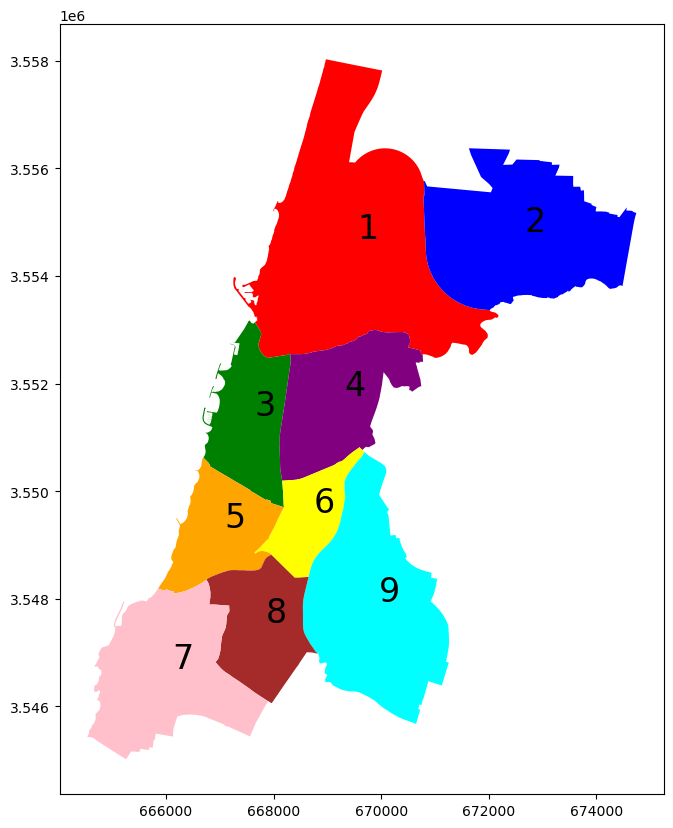

In [3]:
ta_q['index'] = ta_q.index

# Define a list of colors
color_map = {
    1: 'red', 2: 'blue', 3: 'green', 4: 'purple',
    5: 'orange', 6: 'yellow', 7: 'pink', 8: 'brown', 9: 'cyan'
}

# Basic plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each shape with a different color from the list
for idx, row in ta_q.iterrows():
    color = color_map[row['krova']]  # Cycle through the colors list
    gpd.GeoSeries([row['geometry']]).plot(ax=ax, color=color)

    # Get the centroid of the polygon to place the text
    centroid = row['geometry'].centroid
    ax.annotate(text=row['krova'], xy=(centroid.x, centroid.y), 
                xytext=(3, 3), textcoords="offset points",
                fontsize=24, color='black')

plt.show()

In [4]:
# Exclude micro mobility
BICYCLE = 15
SCOOTER = 21
E_BICYCLE = 23
micro_m = [SCOOTER, E_BICYCLE, BICYCLE]


In [5]:
# Load original accident data
i_m_h_ta_gdf = gpd.read_parquet('./csv_tables/i_m_h_ta_gdf.parquet')

In [6]:
# Accidents that are not MM
i_m_h_ta_no_mm_gdf = i_m_h_ta_gdf[~(i_m_h_ta_gdf.involve_vehicle_type.isin(micro_m))].copy()

In [7]:
# Accidents that are just MM
i_m_h_ta_mm_gdf =  gpd.read_parquet('./csv_tables/i_m_h_ta_mm_gdf.parquet')
display(i_m_h_ta_mm_gdf.crs)
i_m_h_ta_mm_gdf.head(5)

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

accident_id  provider_and_id  provider_code  file_type_police  \
41    2013001368      32013001368              3                 3   
50    2013001742      32013001742              3                 3   
131   2013001350      12013001350              1                 1   
196   2013000147      12013000147              1                 1   
197   2013000147      12013000147              1                 1   

     involved_type involved_type_hebrew  license_acquiring_date  age_group  \
41               2             נהג נפגע                       0          6   
50               2             נהג נפגע                       0          7   
131              2             נהג נפגע                       0          5   
196              2             נהג נפגע                       0          8   
197              2             נהג נפגע                       0          6   

    age_group_hebrew  sex  ... vehicle_attribution  \
41             25-29    1  ...                 1.0   
50             30-34    2  ...                 1.0   
131            20-24    1  ...                 1.0   
196            35-39    1  ...                 1.0   
197            25-29    1  ...                 1.0   

     vehicle_attribution_hebrew seats  total_weight total_weight_hebrew  \
41                       ישראלי  99.0           0.0             לא ידוע   
50                       ישראלי  99.0           0.0             לא ידוע   
131                      ישראלי  99.0           0.0             לא ידוע   
196                      ישראלי  99.0           0.0             לא ידוע   
197                      ישראלי  99.0           0.0             לא ידוע   

     vehicle_damage vehicle_damage_hebrew  urban_intersection  \
41              4.0               אין נזק                 NaN   
50              4.0               אין נזק                 NaN   
131             4.0               אין נזק                 NaN   
196             2.0                בינוני           9110323.0   
197             2.0                בינוני           9110323.0   

           accident_date                        geometry  
41   2013-07-27 01:00:00  POINT (667544.749 3549959.961)  
50   2013-10-07 01:30:00  POINT (667286.918 3548726.540)  
131  2013-08-25 01:00:00  POINT (667023.688 3548785.170)  
196  2013-09-19 00:00:00  POINT (668158.751 3551284.678)  
197  2013-09-19 00:00:00  POINT (668158.751 3551284.678)  

[5 rows x 162 columns]

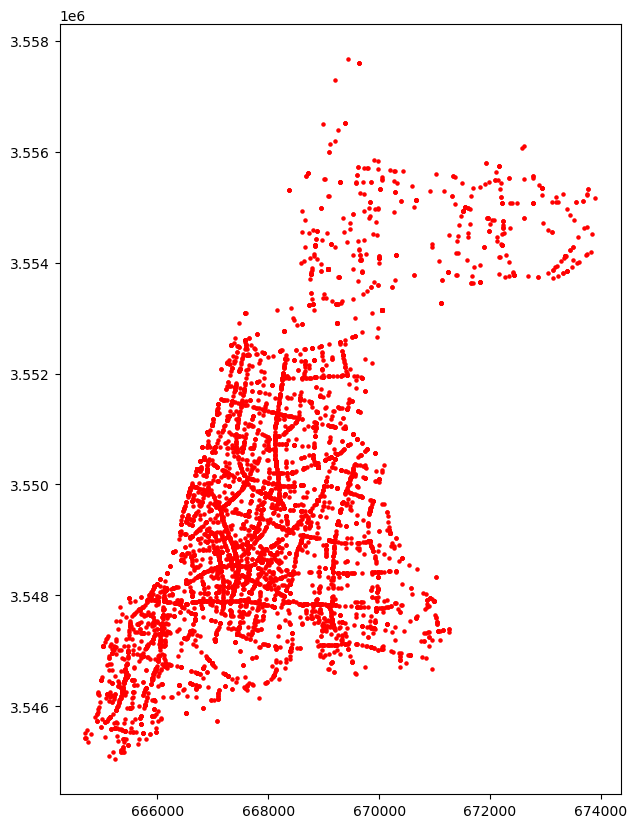

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )
plt.show()

In [9]:
bp_ta_bp_and_meta = gpd.read_parquet('./csv_tables/bp_ta_bp_and_meta.parquet')
bp_ta_bp_and_meta.head(5)

oid_shvil  msorech           dateimport  create_year  \
0          1    95.10  14/08/2024 02:30:05         2012   
1          2   201.14  14/08/2024 02:30:05         2013   
2          3   696.31  14/08/2024 02:30:05         2004   
3          4   659.20  14/08/2024 02:30:05         2018   
4          5   362.67  14/08/2024 02:30:05         2018   

                                   shemmikta create_date  \
0                       נמיר מיוניצ'מן דרומה        None   
1                 פרופס מנמיר עד קדושי השואה        None   
2   יאיר רוזנבלום מאורי צבי גרינברג עד פרופס        None   
3                   קק"ל מנמיר עד חיים לבנון        None   
4  רקנאטי בגינה מקרן קיימת לישראל עד אחימאיר        None   

                                            geometry  width direction  bitzua  \
0  LINESTRING (669823.985 3557373.860, 669855.549...    2.5   דו סטרי    2012   
1  LINESTRING (669232.834 3555478.027, 669169.381...    2.5   דו סטרי    2013   
2  LINESTRING (669232.637 3555478.023, 669249.025...    2.1   דו סטרי    2004   
3  LINESTRING (669354.261 3555417.055, 669410.178...    2.5   דו סטרי    2018   
4  LINESTRING (669946.350 3555344.516, 669962.261...    2.0   דו סטרי    2018   

  miflas date_created  
0   None         None  
1   None         None  
2   None         None  
3  מדרכה         None  
4   None   30/06/2018

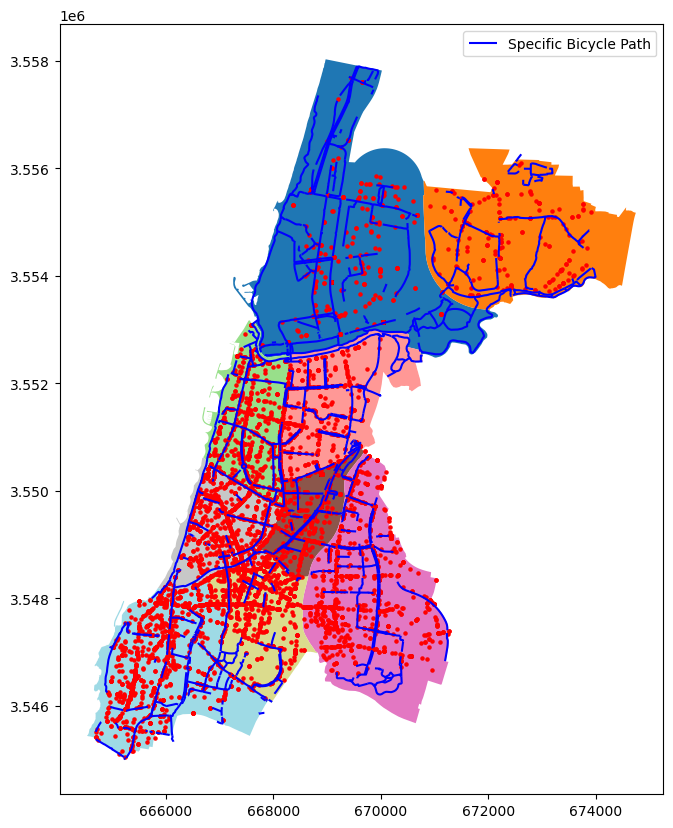

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

ta_q.plot(ax=ax, cmap='tab20', legend=True,)
bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )

plt.legend()
plt.show()

In [11]:
ta_streets = gpd.read_file('./csv_tables/TA_streets_20240724_031704/Streets.shp')
ta_streets

oidrechov  krechov      trechov         shemangli  mslamas  tsug  \
0           1.0    915.0  הרוגי מלכות   HARUGEY MALKHOT    336.0  רחוב   
1           2.0      0.0            0            UKNOWN      0.0  רחוב   
2           3.0    265.0      אמסטרדם         AMSTERDAM    516.0  רחוב   
3           4.0    644.0    אלון יגאל      YIG'AL ALLON   2524.0  רחוב   
4           5.0    634.0      מרגולין          MARGOLIN   2649.0  רחוב   
...         ...      ...          ...               ...      ...   ...   
8874     9851.0   3007.0   שבטי ישראל  SHIVTEY YISRA'EL   1983.0  רחוב   
8875     9852.0   3058.0  אבינרי יצחק           AVINERY   2027.0  רחוב   
8876     9853.0   3058.0  אבינרי יצחק           AVINERY   2027.0  רחוב   
8877     9855.0   3907.0         3907              None   1703.0  רחוב   
8878     9857.0     34.0        מטלון           MATALON   2327.0  רחוב   

      kkivun   UniqueId       shemarvit  kreka  \
0        0.0  507-10001       قتل مملكة  100.0   
1        3.0  507-10002            None  100.0   
2        1.0  507-10003        أمستردام  100.0   
3        0.0  507-10004      ألون ييغال  200.0   
4        1.0  507-10005        مارغولين  100.0   
...      ...        ...             ...    ...   
8874     0.0  507-17843   قبائل إسرائيل  100.0   
8875     0.0  507-20562  Avinri Yitzhak  100.0   
8876     0.0  507-20563  Avinri Yitzhak  100.0   
8877     0.0  507-21960            3907  100.0   
8878     0.0  507-21966         ميتالون  100.0   

                                               geometry  
0     LINESTRING (672865.880 3554095.253, 672895.216...  
1     LINESTRING (666990.498 3551436.940, 667065.337...  
2     LINESTRING (667879.712 3551424.162, 667940.741...  
3     LINESTRING (669570.036 3550420.535, 669581.404...  
4     LINESTRING (669329.153 3548322.758, 669409.403...  
...                                                 ...  
8874  LINESTRING (665771.816 3547023.159, 665760.256...  
8875  LINESTRING (665585.719 3547178.152, 665627.936...  
8876  LINESTRING (665700.142 3547064.296, 665759.119...  
8877  LINESTRING (665087.059 3546677.092, 665075.120...  
8878  LINESTRING (666917.433 3548291.622, 666930.486...  

[8879 rows x 11 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


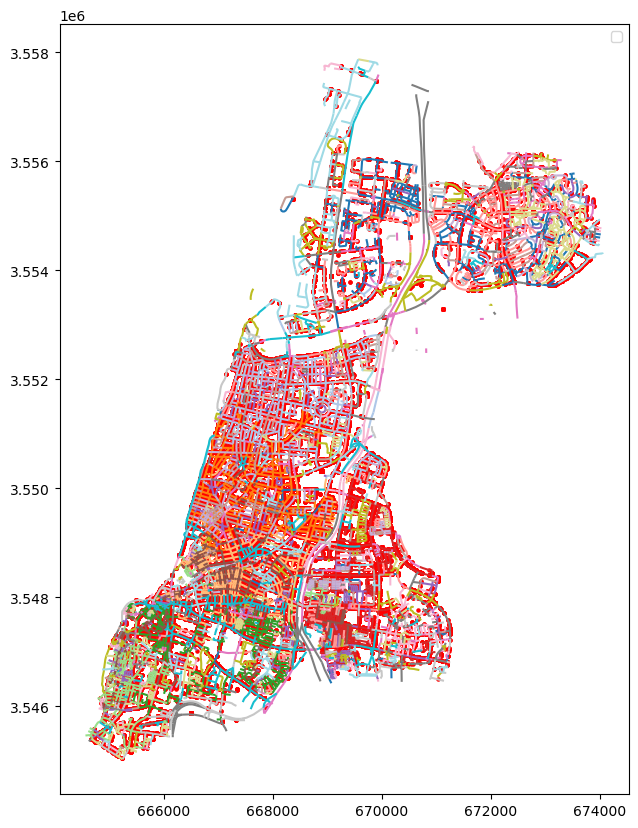

In [176]:

fig, ax = plt.subplots(figsize=(10, 10))
i_m_h_ta_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )
ta_streets.plot(ax=ax, cmap='tab20')
plt.legend()
plt.show()

### Creating Crossroad data

#### Loading crosswalk data:

In [13]:
from shapely.ops import unary_union

In [14]:
# Loading and checking CRS

ta_crossroads = gpd.read_file('./../../Downloads/811/811/811.shp')
print(ta_crossroads.crs)

ta_crossroads = ta_crossroads.to_crs('32636')

ta_crossroads_ = ta_crossroads.copy()
print(ta_crossroads_.crs)

print('shape',ta_crossroads_.shape)

EPSG:2039
EPSG:32636
shape (7637, 11)


In [15]:
ta_crossroads_.head()

traffic_si  traffic__1  traffic_su  last_updat  status_dat  survey_dat  \
0     2040439         811    9.735025  2017-10-01  2017-09-28  2017-09-15   
1     2031701         811    6.523980  2017-10-15  2017-10-04  2017-09-25   
2     2012851         811    3.832506  2017-10-15  2017-10-04  2017-09-20   
3     2009209         811    4.218764  2018-03-06  2017-08-31  2017-08-02   
4     1076995         811    6.469185  2019-01-13  2019-01-10  2019-01-03   

            date_impor  Shape_Leng subject_ch            Descriptio  \
0  15/05/2024 02:28:24   30.000006       None  מעבר חציה להולכי רגל   
1  15/05/2024 02:28:24   20.999978       None  מעבר חציה להולכי רגל   
2  15/05/2024 02:28:24   12.000106       None  מעבר חציה להולכי רגל   
3  15/05/2024 02:28:24   15.000033       None  מעבר חציה להולכי רגל   
4  15/05/2024 02:28:24   21.000049       None  מעבר חציה להולכי רגל   

                                            geometry  
0  MULTILINESTRING ((669691.050 3557664.775, 6696...  
1  MULTILINESTRING ((670184.042 3553411.660, 6701...  
2  MULTILINESTRING ((669406.291 3552768.178, 6694...  
3  MULTILINESTRING ((669634.554 3555705.217, 6696...  
4  MULTILINESTRING ((665268.696 3545605.810, 6652...

Plotting Crosswalks

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


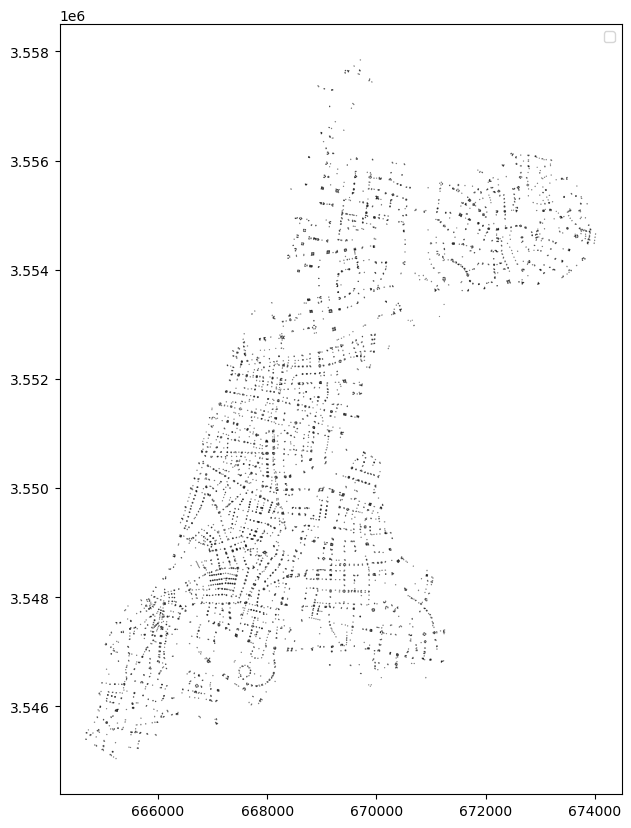

In [175]:
fig, ax = plt.subplots(figsize=(10, 10))
ta_crossroads_.plot(ax=ax, color='black', linewidth=5, alpha=0.5)

plt.legend()
plt.show()

Plotting specific crosswalks that I found in later exploration.

1065, 1058, 1430, 1709, 962, 1464, 874, 1384, 685, 965

In [17]:
specific_crosswalks = [1065]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


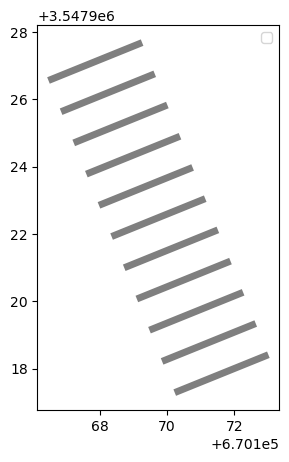

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
ta_crossroads[ta_crossroads.index.isin(specific_crosswalks)].plot(ax=ax, color='black', linewidth=5, alpha=0.5)

plt.legend()
plt.show()

Converting multi string crosswalk to a polygon and then combining different crosswalks that are at proximity to become a single polygon hence a crossroad

In [19]:
# Buffer each geometry and create convex hull if needed
ta_crossroads_['geometry'] = ta_crossroads_.geometry.convex_hull.buffer(10)  # Adjust buffer size

# Combine all geometries into a single multipolygon with merged overlaps
# This step will merge any overlapping polygons into a single geometry
merged_geometry = unary_union(ta_crossroads_.geometry)

# If you want each connected component as a separate polygon, convert the multipolygon back to individual polygons
crossroads_poly = gpd.GeoDataFrame(geometry=[merged_geometry], crs=ta_crossroads_.crs)

# Explode into individual polygons if merged into a MultiPolygon
crossroads_poly = crossroads_poly.explode(index_parts=True).reset_index(drop=True)

In [20]:
gpd.GeoDataFrame(geometry=[merged_geometry], crs=ta_crossroads_.crs)

geometry
0  MULTIPOLYGON (((665236.305 3545032.614, 665235...

In [21]:
crossroads_poly

geometry
0     POLYGON ((665236.305 3545032.614, 665235.706 3...
1     POLYGON ((665191.334 3545061.628, 665190.763 3...
2     POLYGON ((665152.023 3545087.512, 665151.480 3...
3     POLYGON ((665169.380 3545149.282, 665169.097 3...
4     POLYGON ((665005.047 3545179.336, 665004.391 3...
...                                                 ...
2909  POLYGON ((666639.398 3549715.946, 666638.841 3...
2910  POLYGON ((667951.101 3549721.718, 667950.866 3...
2911  POLYGON ((668095.419 3549718.909, 668095.180 3...
2912  POLYGON ((667358.461 3549733.296, 667357.698 3...
2913  POLYGON ((667695.956 3549731.804, 667695.914 3...

[2914 rows x 1 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


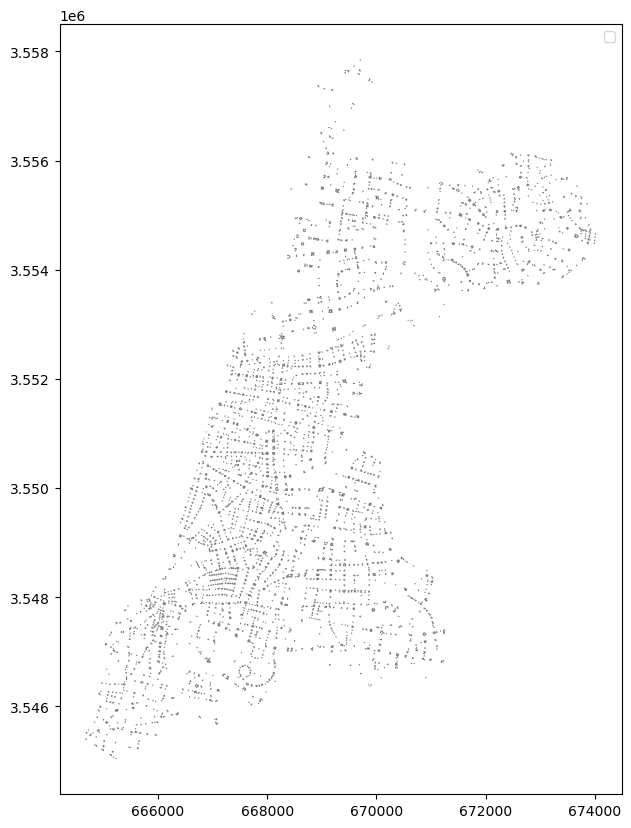

In [174]:
fig, ax = plt.subplots(figsize=(10, 10))
crossroads_poly.plot(ax=ax, color='black', linewidth=5, alpha=0.5)

plt.legend()
plt.show()

Plotting the specific crosswalk after preforming the conversion.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


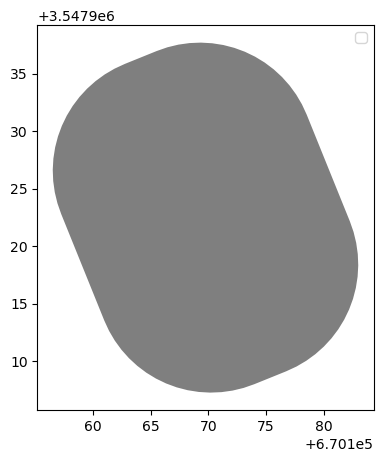

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
ta_crossroads_[ta_crossroads_.index.isin(specific_crosswalks)].plot(ax=ax, color='black', linewidth=5, alpha=0.5)

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


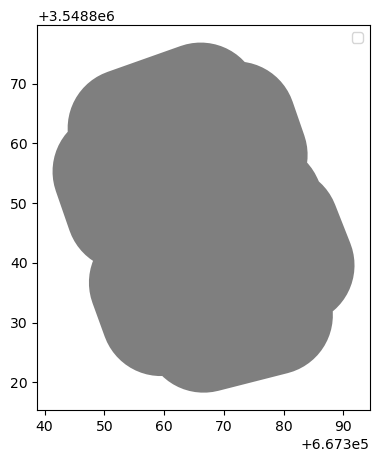

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))
crossroads_poly[crossroads_poly.index.isin(specific_crosswalks)].plot(ax=ax, color='black', linewidth=5, alpha=0.5)

plt.legend()
plt.show()

#### Get the accidents that intersect the crosswalks

In [25]:
i_m_h_ta_mm_gdf.shape

(8789, 162)

Removing participants in the same accidents so we don't have more accidents.

Later we will analyze all participants when we want to check severity.

In [26]:
i_m_h_ta_mm_gdf_ = i_m_h_ta_mm_gdf.drop_duplicates(subset=['provider_and_id'])
i_m_h_ta_mm_gdf_ = i_m_h_ta_mm_gdf_[i_m_h_ta_mm_gdf_.location_accuracy == 1]

i_m_h_ta_mm_gdf_.shape

(4997, 162)

Getting the accidents that intersect our created crossroads.

In [27]:
i_m_h_ta_mm_crossroads_gdf = gpd.sjoin(i_m_h_ta_mm_gdf_, crossroads_poly, how='inner', predicate='intersects')

In [28]:
i_m_h_ta_mm_crossroads_gdf_ = i_m_h_ta_mm_crossroads_gdf.drop_duplicates(subset=['provider_and_id'])
i_m_h_ta_mm_crossroads_gdf_

accident_id  provider_and_id  provider_code  file_type_police  \
196      2013000147      12013000147              1                 1   
251      2013001755      32013001755              3                 3   
257      2013002105      32013002105              3                 3   
349      2013001346      32013001346              3                 3   
455      2013002036      12013002036              1                 1   
...             ...              ...            ...               ...   
111269   2024098273      32024098273              3                 3   
111326   2024098833      32024098833              3                 3   
111332   2024090432      12024090432              1                 1   
111345   2024096932      32024096932              3                 3   
111394   2024095204      32024095204              3                 3   

        involved_type involved_type_hebrew  license_acquiring_date  age_group  \
196                 2             נהג נפגע                       0          8   
251                 2             נהג נפגע                    2005          6   
257                 1                  נהג                       0          7   
349                 2             נהג נפגע                       0          5   
455                 2             נהג נפגע                       0          6   
...               ...                  ...                     ...        ...   
111269              2             נהג נפגע                    1980         13   
111326              1                  נהג                       0         99   
111332              2             נהג נפגע                    1996         10   
111345              2             נהג נפגע                    2023          4   
111394              2             נהג נפגע                    2013          7   

       age_group_hebrew  sex  ... vehicle_attribution_hebrew  seats  \
196               35-39    1  ...                     ישראלי   99.0   
251               25-29    1  ...                     ישראלי   99.0   
257               30-34    1  ...                     ישראלי   99.0   
349               20-24    2  ...                     ישראלי   99.0   
455               25-29    2  ...                     ישראלי   99.0   
...                 ...  ...  ...                        ...    ...   
111269            60-64    1  ...                     ישראלי   99.0   
111326          לא ידוע    0  ...                     ישראלי   99.0   
111332            45-49    2  ...                     ישראלי   99.0   
111345            15-19    1  ...                     ישראלי   99.0   
111394            30-34    1  ...                     ישראלי   99.0   

       total_weight  total_weight_hebrew vehicle_damage  \
196             0.0              לא ידוע            2.0   
251             0.0              לא ידוע            4.0   
257             0.0              לא ידוע            1.0   
349             0.0              לא ידוע            4.0   
455             0.0              לא ידוע            4.0   
...             ...                  ...            ...   
111269          0.0              לא ידוע            1.0   
111326          0.0              לא ידוע            4.0   
111332          0.0              לא ידוע            1.0   
111345          0.0              לא ידוע            4.0   
111394          0.0              לא ידוע            4.0   

        vehicle_damage_hebrew urban_intersection        accident_date  \
196                    בינוני          9110323.0  2013-09-19 00:00:00   
251                   אין נזק         11670545.0  2013-11-23 01:30:00   
257                        קל          7540321.0  2013-01-01 02:15:00   
349                   אין נזק            10335.0  2013-09-06 01:00:00   
455                   אין נזק          7190312.0  2013-07-25 02:00:00   
...                       ...                ...                  ...   
111269                     קל         15270924.0  2024-03-31 08:00:00   
111326      

In [29]:
i_m_h_ta_mm_crossroads_gdf_.value_counts(subset='index_right')

index_right
1065    32
1058    30
1430    21
1709    19
962     18
        ..
1201     1
1196     1
1193     1
1192     1
0        1
Name: count, Length: 749, dtype: int64

### Creating crossroad name

I have tried using i_m_h_ta_mm_crossroads_gdf street1_hebrew and street2_hebrew to create the crossroad name.<br>
But there are cases where there is only 1 street1_hebrew and nan street2_hebrew so the result is nan<br>
OR there are several streets connecting and each accidents has a different street1_hebrew name 4 times for the same crossroad.

Will try to get the name by sjoin on ta_streets.

In [30]:
crossroads_poly

geometry
0     POLYGON ((665236.305 3545032.614, 665235.706 3...
1     POLYGON ((665191.334 3545061.628, 665190.763 3...
2     POLYGON ((665152.023 3545087.512, 665151.480 3...
3     POLYGON ((665169.380 3545149.282, 665169.097 3...
4     POLYGON ((665005.047 3545179.336, 665004.391 3...
...                                                 ...
2909  POLYGON ((666639.398 3549715.946, 666638.841 3...
2910  POLYGON ((667951.101 3549721.718, 667950.866 3...
2911  POLYGON ((668095.419 3549718.909, 668095.180 3...
2912  POLYGON ((667358.461 3549733.296, 667357.698 3...
2913  POLYGON ((667695.956 3549731.804, 667695.914 3...

[2914 rows x 1 columns]

In [31]:
ta_streets

oidrechov  krechov      trechov         shemangli  mslamas  tsug  \
0           1.0    915.0  הרוגי מלכות   HARUGEY MALKHOT    336.0  רחוב   
1           2.0      0.0            0            UKNOWN      0.0  רחוב   
2           3.0    265.0      אמסטרדם         AMSTERDAM    516.0  רחוב   
3           4.0    644.0    אלון יגאל      YIG'AL ALLON   2524.0  רחוב   
4           5.0    634.0      מרגולין          MARGOLIN   2649.0  רחוב   
...         ...      ...          ...               ...      ...   ...   
8874     9851.0   3007.0   שבטי ישראל  SHIVTEY YISRA'EL   1983.0  רחוב   
8875     9852.0   3058.0  אבינרי יצחק           AVINERY   2027.0  רחוב   
8876     9853.0   3058.0  אבינרי יצחק           AVINERY   2027.0  רחוב   
8877     9855.0   3907.0         3907              None   1703.0  רחוב   
8878     9857.0     34.0        מטלון           MATALON   2327.0  רחוב   

      kkivun   UniqueId       shemarvit  kreka  \
0        0.0  507-10001       قتل مملكة  100.0   
1        3.0  507-10002            None  100.0   
2        1.0  507-10003        أمستردام  100.0   
3        0.0  507-10004      ألون ييغال  200.0   
4        1.0  507-10005        مارغولين  100.0   
...      ...        ...             ...    ...   
8874     0.0  507-17843   قبائل إسرائيل  100.0   
8875     0.0  507-20562  Avinri Yitzhak  100.0   
8876     0.0  507-20563  Avinri Yitzhak  100.0   
8877     0.0  507-21960            3907  100.0   
8878     0.0  507-21966         ميتالون  100.0   

                                               geometry  
0     LINESTRING (672865.880 3554095.253, 672895.216...  
1     LINESTRING (666990.498 3551436.940, 667065.337...  
2     LINESTRING (667879.712 3551424.162, 667940.741...  
3     LINESTRING (669570.036 3550420.535, 669581.404...  
4     LINESTRING (669329.153 3548322.758, 669409.403...  
...                                                 ...  
8874  LINESTRING (665771.816 3547023.159, 665760.256...  
8875  LINESTRING (665585.719 3547178.152, 665627.936...  
8876  LINESTRING (665700.142 3547064.296, 665759.119...  
8877  LINESTRING (665087.059 3546677.092, 665075.120...  
8878  LINESTRING (666917.433 3548291.622, 666930.486...  

[8879 rows x 11 columns]

In [32]:
crossroads_poly

geometry
0     POLYGON ((665236.305 3545032.614, 665235.706 3...
1     POLYGON ((665191.334 3545061.628, 665190.763 3...
2     POLYGON ((665152.023 3545087.512, 665151.480 3...
3     POLYGON ((665169.380 3545149.282, 665169.097 3...
4     POLYGON ((665005.047 3545179.336, 665004.391 3...
...                                                 ...
2909  POLYGON ((666639.398 3549715.946, 666638.841 3...
2910  POLYGON ((667951.101 3549721.718, 667950.866 3...
2911  POLYGON ((668095.419 3549718.909, 668095.180 3...
2912  POLYGON ((667358.461 3549733.296, 667357.698 3...
2913  POLYGON ((667695.956 3549731.804, 667695.914 3...

[2914 rows x 1 columns]

In [33]:
crossroads_index = crossroads_poly.index
crossroads_index

RangeIndex(start=0, stop=2914, step=1)

In [34]:
ta_street_crossroads = gpd.sjoin(ta_streets,crossroads_poly)

# ta_street_crossroads = ta_street_crossroads.drop_duplicates('krechov')
# ta_street_crossroads

In [35]:
# checking discrepancy between crossroads_poly and ta_streets join

ta_street_crossroads.index_right.values

array([2344, 2353, 1841, ...,  312,  197,  832], dtype=int64)

In [36]:
# Convert RangeIndex to a set
range_set = set(crossroads_index)

# Convert the array to a set
array_set = set(ta_street_crossroads.index_right.values)

# Find the intersection
intersection = crossroads_index.intersection(array_set)

# Find the values in the RangeIndex that are not in the array
difference = crossroads_index.difference(array_set)

# Convert results to sorted lists if needed
intersection_list = sorted(intersection)
difference_list = sorted(difference)

# Print results
print("Intersection:", intersection_list)
print("Difference:", difference_list)

Intersection: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 128, 129, 130, 131, 132, 133, 135, 136, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,

In [37]:
len(difference_list)

148

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


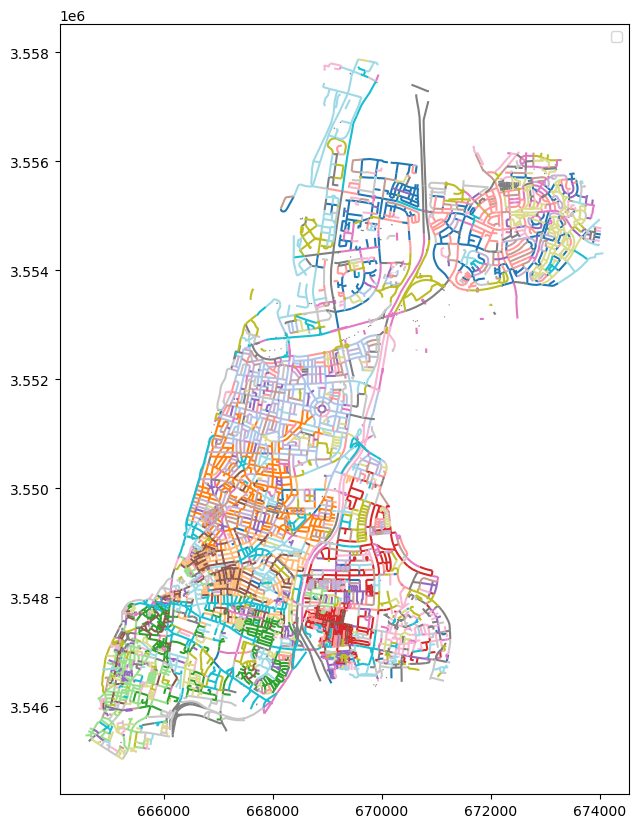

In [173]:
fig, ax = plt.subplots(figsize=(10, 10))
crossroads_poly[crossroads_poly.index.isin(difference_list)].plot(ax=ax, color='black', linewidth=5, alpha=0.5)
ta_streets.plot(ax=ax, cmap='tab20')

plt.legend()
plt.show()

In [39]:
ta_street_crossroads.index_right.value_counts()

index_right
2907    11
609      9
880      8
312      8
2689     8
        ..
2356     1
2343     1
2390     1
1059     1
1728     1
Name: count, Length: 2766, dtype: int64

In [40]:
ta_street_crossroads[ta_street_crossroads.index_right == 2907]

oidrechov  krechov      trechov         shemangli  mslamas  tsug  \
1199     1216.0    406.0  המלך ג'ורג'  HA-MELEKH GEORGE    738.0  רחוב   
1200     1217.0    406.0  המלך ג'ורג'  HA-MELEKH GEORGE    738.0  רחוב   
1201     1218.0    426.0      אלמונית    ALMONIT SIMTAT   1118.0  סמטת   
1202     1219.0    406.0  המלך ג'ורג'  HA-MELEKH GEORGE    738.0  רחוב   
1203     1220.0    406.0  המלך ג'ורג'  HA-MELEKH GEORGE    738.0  רחוב   
1204     1221.0     81.0        המכבי          HAMAKABI   1133.0  רחוב   
3708     3765.0    425.0       פלונית     PLONIT SIMTAT   1120.0  סמטת   
4013     4084.0    427.0   אלו מציאות       ELU METSIOT   1136.0  סמטת   
4379     4457.0     21.0       העבודה          HA'AVODA   1114.0  רחוב   
4380     4458.0    406.0  המלך ג'ורג'  HA-MELEKH GEORGE    738.0  רחוב   
6109     6339.0    406.0  המלך ג'ורג'  HA-MELEKH GEORGE    738.0  רחוב   

      kkivun   UniqueId    shemarvit  kreka  \
1199     0.0  507-11375  الملك جورج'  200.0   
1200     0.0  507-11376  الملك جورج'  200.0   
1201     0.0  507-11377        مجهول   50.0   
1202     0.0  507-11378  الملك جورج'  200.0   
1203     0.0  507-11379  الملك جورج'  200.0   
1204     1.0  507-11380        مكابي  100.0   
3708     0.0  507-14399         بيلي   50.0   
4013     1.0  507-14769    هذه حقيقة   50.0   
4379     2.0  507-15176        العمل  100.0   
4380     2.0  507-15177  الملك جورج'  200.0   
6109     2.0  507-17469  الملك جورج'  200.0   

                                               geometry  index_right  
1199  LINESTRING (667265.096 3549660.432, 667295.312...         2907  
1200  LINESTRING (667320.706 3549715.778, 667358.804...         2907  
1201  LINESTRING (667320.706 3549715.778, 667328.219...         2907  
1202  LINESTRING (667306.901 3549703.870, 667320.706...         2907  
1203  LINESTRING (667295.312 3549693.647, 667306.901...         2907  
1204  LINESTRING (667174.483 3549767.531, 667306.901...         2907  
3708  LINESTRING (667295.312 3549693.647, 667301.920...         2907  
4013  LINESTRING (667216.261 3549675.030, 667245.791...         2907  
4379  LINESTRING (667265.096 3549660.432, 667414.948...         2907  
4380  LINESTRING (667245.791 3549646.192, 667265.096...         2907  
6109  LINESTRING (667194.557 3549608.406, 667245.791...         2907

In [41]:
# unique_counts = (
#     i_m_h_ta_mm_crossroads_gdf.groupby('index_right')
#     .agg(
#         unique_street1_hebrew=('street1_hebrew', lambda x: x.nunique(dropna=True)),
#         unique_street2_hebrew=('street2_hebrew', lambda x: x.nunique(dropna=True))
#     )
#     .reset_index()
# )

In [42]:
# u_c_street_for_crossroad = (ta_street_crossroads.groupby('index_right')
#                             .agg(num_unique_streets)
#                             )

Getting top 10 crossroad by accidents count.

In [43]:
t10_crossroad_id = i_m_h_ta_mm_crossroads_gdf.value_counts(subset='index_right').head(10).index
print(t10_crossroad_id)
i_m_h_ta_mm_crossroads_gdf_t10 = i_m_h_ta_mm_crossroads_gdf[i_m_h_ta_mm_crossroads_gdf.index_right.isin(t10_crossroad_id)]
i_m_h_ta_mm_crossroads_gdf_t10

Index([1065, 1058, 1430, 1709, 962, 1464, 874, 1384, 685, 965], dtype='int64', name='index_right')


accident_id  provider_and_id  provider_code  file_type_police  \
580      2013004110      12013004110              1                 1   
2759     2013015911      12013015911              1                 1   
4865     2013024676      12013024676              1                 1   
7642     2013037036      12013037036              1                 1   
9775     2013043911      12013043911              1                 1   
...             ...              ...            ...               ...   
109867   2024040748      12024040748              1                 1   
109917   2024041727      12024041727              1                 1   
109962   2024037537      32024037537              3                 3   
110204   2024051752      32024051752              3                 3   
111249   2024095525      32024095525              3                 3   

        involved_type involved_type_hebrew  license_acquiring_date  age_group  \
580                 2             נהג נפגע                       0          7   
2759                2             נהג נפגע                       0          7   
4865                1                  נהג                       0          7   
7642                1                  נהג                       0          9   
9775                2             נהג נפגע                    2002          6   
...               ...                  ...                     ...        ...   
109867              2             נהג נפגע                    2008          7   
109917              2             נהג נפגע                    1985         14   
109962              1                  נהג                       0         99   
110204              2             נהג נפגע                       0         99   
111249              2             נהג נפגע                       0         99   

       age_group_hebrew  sex  ... vehicle_attribution_hebrew  seats  \
580               30-34    1  ...                     ישראלי   99.0   
2759              30-34    2  ...                     ישראלי   99.0   
4865              30-34    1  ...                     ישראלי   99.0   
7642              40-44    1  ...                     ישראלי   99.0   
9775              25-29    1  ...                     ישראלי   99.0   
...                 ...  ...  ...                        ...    ...   
109867            30-34    1  ...                     ישראלי   99.0   
109917            65-69    1  ...                     ישראלי   99.0   
109962          לא ידוע    0  ...                     ישראלי   99.0   
110204          לא ידוע    0  ...                     ישראלי   99.0   
111249          לא ידוע    0  ...                     ישראלי   99.0   

       total_weight  total_weight_hebrew vehicle_damage  \
580             0.0              לא ידוע            1.0   
2759            0.0              לא ידוע            1.0   
4865            0.0              לא ידוע            1.0   
7642            0.0              לא ידוע            4.0   
9775            0.0              לא ידוע            1.0   
...             ...                  ...            ...   
109867          0.0              לא ידוע            4.0   
109917          0.0              לא ידוע            4.0   
109962          0.0              לא ידוע            4.0   
110204          0.0              לא ידוע            1.0   
111249          0.0              לא ידוע            1.0   

        vehicle_damage_hebrew urban_intersection        accident_date  \
580                        קל         12280911.0  2013-04-24 06:30:00   
2759                       קל         13320815.0  2013-04-22 09:45:00   
4865                       קל         12280911.0  2013-09-25 12:15:00   
7642                  אין נזק                NaN  2013-02-25 15:30:00   
9775                       קל         12950556.0  2013-07-04 16:45:00   
...                       ...                ...                  ...   
109867                אין נזק         15130624.0  2024-01-08 12:00:00   
109917      

Creating crossroads name

C:\Users\itay8\AppData\Local\Temp\ipykernel_15096\4247611794.py:28: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


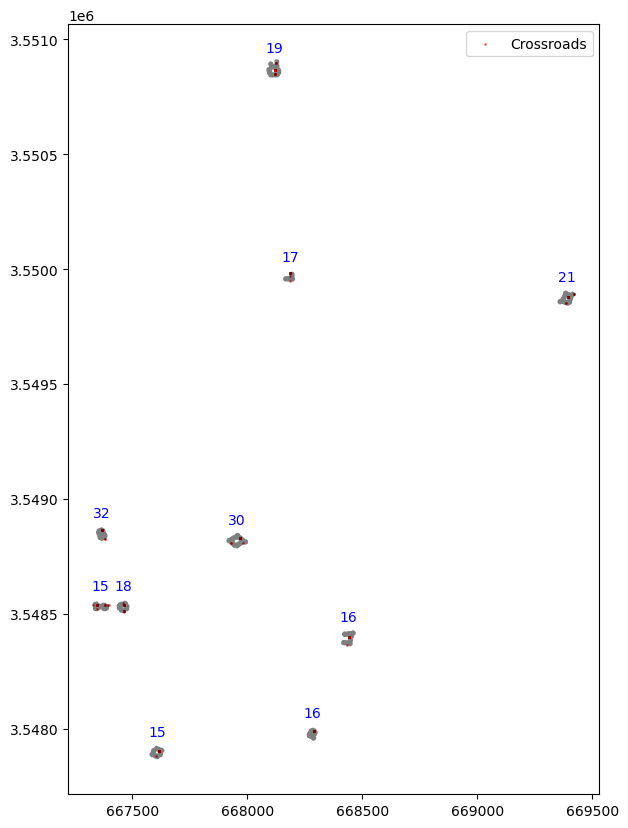

In [44]:
# Step 1: Get the count of `index_right`
v_counts_crossroad_idx = i_m_h_ta_mm_crossroads_gdf_.value_counts(subset='index_right')

# Step 2: Prepare the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Step 3: Plot points and polygons
# Plot the points
i_m_h_ta_mm_crossroads_gdf_t10.plot(
    ax=ax, color='red', marker='o', markersize=1, alpha=0.5, label="Crossroads"
)

# Plot the polygons with matching `index_right`
filtered_crossroads = crossroads_poly[crossroads_poly.index.isin(i_m_h_ta_mm_crossroads_gdf_t10.index_right)]
filtered_crossroads.plot(ax=ax, color='black', alpha=0.5, label="Polygons")

# Step 4: Annotate polygons with v_counts_crossroad_idx
for idx, row in filtered_crossroads.iterrows():
    count = v_counts_crossroad_idx.get(idx, 0)  # Get the count for this index; default to 0 if not found
    centroid = row.geometry.centroid  # Calculate the centroid of the polygon
    ax.text(
        centroid.x, centroid.y + 60,  # Add an offset to the y-coordinate
        str(count),  # The text to display
        fontsize=10, color="blue", ha='center', va='bottom', 
    )

# Step 5: Customize legend and show the plot
plt.legend()
plt.show()


Plotting top 10 crossroads by from 2013 - 2023 and number of accidents

Getting the top 10 crossroad_ index right by year



### Attempt 2 in creating the crossroads

Going over ta_streets and creating valid crossroads from the intersections between street parts.

In [45]:
# Import necessary libraries
from shapely.geometry import LineString
import geopandas as gpd

def split_linestrings_by_length(gdf, split_length=10):
    """Split each LineString in a GeoDataFrame into two LineStrings:
    one starting from the start point with the specified length
    and one ending at the endpoint with the specified length."""
    new_rows = []
    
    for i, row in gdf.iterrows():
        geometry = row.geometry
        
        # Check if the geometry is a LineString
        if isinstance(geometry, LineString):
            length = geometry.length
            
            # Ensure the split length is valid
            if split_length * 2 >= length:
                # If the split length exceeds the total length, skip splitting
                continue
            
            # Compute the two split points
            split_point_start = geometry.interpolate(split_length)
            split_point_end = geometry.interpolate(length - split_length)
            
            # Create two new LineStrings
            first_segment = LineString([geometry.coords[0], split_point_start.coords[0]])
            second_segment = LineString([split_point_end.coords[0], geometry.coords[-1]])
            # print('first half',first_segment.length, 'second_half', second_segment.length)
            
            # Append new rows with the original attributes and new geometries
            new_rows.append({**row.to_dict(), "geometry": first_segment})
            new_rows.append({**row.to_dict(), "geometry": second_segment})
    
    # Create a new GeoDataFrame with the split LineStrings
    return gpd.GeoDataFrame(new_rows, crs=gdf.crs)

# Example GeoDataFrame
data = {
    "id": [1, 2],
    "geometry": [
        LineString([(0, 0), (20, 0)]),
        LineString([(0, 0), (0, 30)]),
    ],
}
example_gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")

# Split the LineStrings with a length of 10
split_gdf = split_linestrings_by_length(example_gdf, split_length=10)

# Display the resulting GeoDataFrame
# import ace_tools as tools; tools.display_dataframe_to_user(name="Split LineStrings by Length GeoDataFrame", dataframe=split_gdf)


(16960, 11)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


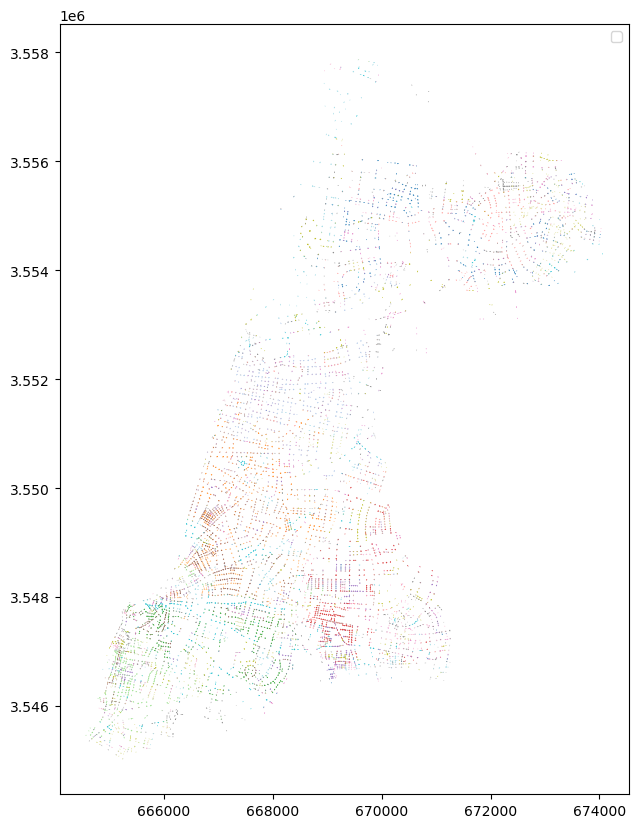

In [172]:
# Split the LineStrings in the example GeoDataFrame
ta_crossroads_from_streets = split_linestrings_by_length(ta_streets)
ta_crossroads_from_streets['geometry'] = ta_crossroads_from_streets.geometry.buffer(5)
print(ta_crossroads_from_streets.shape)

fig, ax = plt.subplots(figsize=(10, 10))
ta_crossroads_from_streets.plot(ax=ax, cmap='tab20')

plt.legend()
plt.show()

In [47]:
combined_polygons = ta_crossroads_from_streets.dissolve().explode()
print(combined_polygons.shape)


combined_polygons['geo_length'] = combined_polygons.geometry.length
combined_polygons = combined_polygons.reset_index().drop(columns=['level_1','level_0'])
combined_polygons

(5628, 11)


C:\Users\itay8\AppData\Local\Temp\ipykernel_15096\2278547393.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  combined_polygons = ta_crossroads_from_streets.dissolve().explode()


oidrechov  krechov      trechov        shemangli  mslamas  tsug  kkivun  \
0           1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1           1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
2           1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
3           1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
4           1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
...         ...      ...          ...              ...      ...   ...     ...   
5623        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
5624        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
5625        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
5626        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
5627        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   

       UniqueId  shemarvit  kreka  \
0     507-10001  قتل مملكة  100.0   
1     507-10001  قتل مملكة  100.0   
2     507-10001  قتل مملكة  100.0   
3     507-10001  قتل مملكة  100.0   
4     507-10001  قتل مملكة  100.0   
...         ...        ...    ...   
5623  507-10001  قتل مملكة  100.0   
5624  507-10001  قتل مملكة  100.0   
5625  507-10001  قتل مملكة  100.0   
5626  507-10001  قتل مملكة  100.0   
5627  507-10001  قتل مملكة  100.0   

                                               geometry  geo_length  
0     POLYGON ((665251.028 3545022.970, 665250.991 3...   69.100794  
1     POLYGON ((665173.003 3545083.704, 665173.279 3...   51.403312  
2     POLYGON ((665136.784 3545100.508, 665137.185 3...   87.109020  
3     POLYGON ((665262.291 3545110.298, 665262.003 3...   51.390955  
4     POLYGON ((665227.787 3545131.528, 665228.177 3...   82.956372  
...                                                 ...         ...  
5623  POLYGON ((669845.350 3557772.019, 669845.346 3...   71.403332  
5624  POLYGON ((669241.826 3557690.173, 669241.781 3...   71.138641  
5625  POLYGON ((669140.042 3557704.879, 669140.522 3...   51.403312  
5626  POLYGON ((669586.350 3557706.521, 669586.804 3...   69.133970  
5627  POLYGON ((669567.411 3557871.865, 669567.505 3...   70.097456  

[5628 rows x 12 columns]

In [48]:
combined_polygons[combined_polygons.geo_length >300]


oidrechov  krechov      trechov        shemangli  mslamas  tsug  kkivun  \
394         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
441         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
600         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
660         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
733         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
792         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
797         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
881         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
891         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
978         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1107        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1113        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1436        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1470        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1619        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1677        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1698        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
2466        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
2497        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
2508        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
2644        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
3044        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   

       UniqueId  shemarvit  kreka  \
394   507-10001  قتل مملكة  100.0   
441   507-10001  قتل مملكة  100.0   
600   507-10001  قتل مملكة  100.0   
660   507-10001  قتل مملكة  100.0   
733   507-10001  قتل مملكة  100.0   
792   507-10001  قتل مملكة  100.0   
797   507-10001  قتل مملكة  100.0   
881   507-10001  قتل مملكة  100.0   
891   507-10001  قتل مملكة  100.0   
978   507-10001  قتل مملكة  100.0   
1107  507-10001  قتل مملكة  100.0   
1113  507-10001  قتل مملكة  100.0   
1436  507-10001  قتل مملكة  100.0   
1470  507-10001  قتل مملكة  100.0   
1619  507-10001  قتل مملكة  100.0   
1677  507-10001  قتل مملكة  100.0   
1698  507-10001  قتل مملكة  100.0   
2466  507-10001  قتل مملكة  100.0   
2497  507-10001  قتل مملكة  100.0   
2508  507-10001  قتل مملكة  100.0   
2644  507-10001  قتل مملكة  100.0   
3044  507-10001  قتل مملكة  100.0   

                                               geometry  geo_length  
394   POLYGON ((665220.022 3546437.888, 665219.901 3...  397.047146  
441   POLYGON ((669087.116 3546513.295, 669087.600 3...  319.089798  
600   POLYGON ((669320.048 3546684.341, 669320.034 3...  335.301705  
660   POLYGON ((669343.979 3546738.237, 669343.987 3...  302.996312  
733   POLYGON ((665208.254 3546799.085, 665208.125 3...  679.407809  
792   POLYGON ((668994.554 3546855.911, 668994.799 3...  339.646468  
797   POLYGON ((669046.092 3546865.995, 669046.582 3...  326.530708  
881   POLYGON ((665142.336 3546949.298, 665142.108 3...  497.254696  
891   POLYGON ((665218.068 3546957.509, 665217.819 3...  312.401531  
978   POLYGON ((665150.577 3547047.155, 665150.971 3...  564.434988  
1107  POLYGON ((665274.053 3547165.269, 665274.030 3...  320.796432  
1113  POLYGON ((669071.067 3547173.092, 669071.042 3...  375.362471  
1436  POLYGON ((669287.772 3547485.783, 669287.772 3...  315.503344  
1470  POLYGON ((669143.894 3547503.090, 669143.846 3...  337.447604  
1619  POLYGON ((665750.746 3547633.319, 665750.672 3...  458.136902  
1677  POLYGON ((665811.002 3547677.700, 665810.927 3...  386.562857  
1698  POLYGON ((668831.112 3547693.765, 668830.992 3...  329.678913  
2466  POLYGON ((666776.940 354

In [49]:
combined_polygons.geo_length.max()

679.4078086770243

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


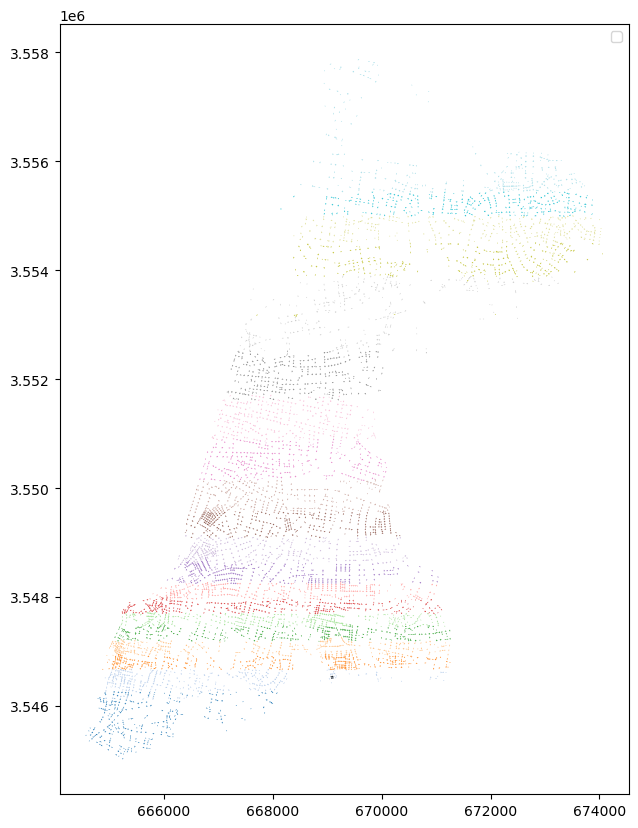

In [171]:
fig, ax = plt.subplots(figsize=(10, 10))
combined_polygons.plot(ax=ax, cmap='tab20')
combined_polygons[combined_polygons.index == 441].plot(ax=ax, color='black')

plt.legend()
plt.show()

In [51]:
joined = gpd.sjoin(ta_streets, combined_polygons[['geometry','geo_length']], how="inner", predicate="intersects")
# joined.groupby('index_right')['trechov']
joined

oidrechov  krechov      trechov        shemangli  mslamas  tsug  kkivun  \
0           1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
0           1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1           2.0      0.0            0           UKNOWN      0.0  רחוב     3.0   
1           2.0      0.0            0           UKNOWN      0.0  רחוב     3.0   
2           3.0    265.0      אמסטרדם        AMSTERDAM    516.0  רחוב     1.0   
...         ...      ...          ...              ...      ...   ...     ...   
8876     9853.0   3058.0  אבינרי יצחק          AVINERY   2027.0  רחוב     0.0   
8877     9855.0   3907.0         3907             None   1703.0  רחוב     0.0   
8877     9855.0   3907.0         3907             None   1703.0  רחוב     0.0   
8878     9857.0     34.0        מטלון          MATALON   2327.0  רחוב     0.0   
8878     9857.0     34.0        מטלון          MATALON   2327.0  רחוב     0.0   

       UniqueId       shemarvit  kreka  \
0     507-10001       قتل مملكة  100.0   
0     507-10001       قتل مملكة  100.0   
1     507-10002            None  100.0   
1     507-10002            None  100.0   
2     507-10003        أمستردام  100.0   
...         ...             ...    ...   
8876  507-20563  Avinri Yitzhak  100.0   
8877  507-21960            3907  100.0   
8877  507-21960            3907  100.0   
8878  507-21966         ميتالون  100.0   
8878  507-21966         ميتالون  100.0   

                                               geometry  index_right  \
0     LINESTRING (672865.880 3554095.253, 672895.216...         4603   
0     LINESTRING (672865.880 3554095.253, 672895.216...         4609   
1     LINESTRING (666990.498 3551436.940, 667065.337...         3858   
1     LINESTRING (666990.498 3551436.940, 667065.337...         3866   
2     LINESTRING (667879.712 3551424.162, 667940.741...         3853   
...                                                 ...          ...   
8876  LINESTRING (665700.142 3547064.296, 665759.119...         1001   
8877  LINESTRING (665087.059 3546677.092, 665075.120...          580   
8877  LINESTRING (665087.059 3546677.092, 665075.120...          590   
8878  LINESTRING (666917.433 3548291.622, 666930.486...         2294   
8878  LINESTRING (666917.433 3548291.622, 666930.486...         2300   

      geo_length  
0      87.905884  
0      87.787937  
1      86.827406  
1      51.403312  
2     102.748388  
...          ...  
8876   71.179821  
8877   51.403312  
8877  124.688742  
8878   51.403312  
8878  102.790362  

[17173 rows x 13 columns]

In [52]:
# import geopandas as gpd

def process_trechov_combination(ta_streets, combined_polygons):
    # Step 1: Perform a spatial join
    joined = gpd.sjoin(ta_streets, combined_polygons, how="inner", predicate="intersects")
    
    # Step 2: Group by index of combined_polygons and collect `trechov` names
    trechov_grouped = joined.groupby('index_right')['trechov'].apply(
        lambda trechovs: list(set(trechovs))  # Deduplicate `trechov` names
    )
    
    # Step 3: Add the combined `trechov` and count back to combined_polygons
    combined_polygons['combined_trechov'] = combined_polygons.index.map(trechov_grouped)
    combined_polygons['combined_trechov'] = combined_polygons['combined_trechov'].apply(
        lambda x: x if x is not None else []  # Handle polygons with no matches
    )
    
    # Step 4: Add the count of unique `trechov` names
    combined_polygons['num_trechov'] = combined_polygons['combined_trechov'].apply(len)
    
    return combined_polygons

# Example usage
resulting_combined_polygons = process_trechov_combination(ta_streets, combined_polygons[['geometry','geo_length']].copy())

# Display the updated GeoDataFrame
# import ace_tools as tools; tools.display_dataframe_to_user(name="Polygons with Combined Trechov Data", dataframe=resulting_combined_polygons)
resulting_combined_polygons

geometry  geo_length  \
0     POLYGON ((665251.028 3545022.970, 665250.991 3...   69.100794   
1     POLYGON ((665173.003 3545083.704, 665173.279 3...   51.403312   
2     POLYGON ((665136.784 3545100.508, 665137.185 3...   87.109020   
3     POLYGON ((665262.291 3545110.298, 665262.003 3...   51.390955   
4     POLYGON ((665227.787 3545131.528, 665228.177 3...   82.956372   
...                                                 ...         ...   
5623  POLYGON ((669845.350 3557772.019, 669845.346 3...   71.403332   
5624  POLYGON ((669241.826 3557690.173, 669241.781 3...   71.138641   
5625  POLYGON ((669140.042 3557704.879, 669140.522 3...   51.403312   
5626  POLYGON ((669586.350 3557706.521, 669586.804 3...   69.133970   
5627  POLYGON ((669567.411 3557871.865, 669567.505 3...   70.097456   

               combined_trechov  num_trechov  
0       [ירושלים, הולצברג שמחה]            2  
1          [8186, הולצברג שמחה]            2  
2     [קרוא ברוך, הולצברג שמחה]            2  
3                        [8101]            1  
4            [8186, מייזל זלמן]            2  
...                         ...          ...  
5623                     [2379]            1  
5624                     [2170]            1  
5625                     [2170]            1  
5626        [זלצמן פנינה פרופ']            1  
5627               [2379, 2425]            2  

[5628 rows x 4 columns]

In [53]:
street_names = []
resulting_combined_polygons[resulting_combined_polygons.num_trechov == 1].combined_trechov.apply(lambda x: street_names.append(x[0]))
street_names

['8101',
 '3861',
 'ירושלים',
 '8101',
 '3861',
 '8101',
 'קהילת קנדה',
 'קהילת קנדה',
 'קרוא ברוך',
 'מייזל זלמן',
 'קרוא ברוך',
 'קרוא ברוך',
 'הולצברג שמחה',
 'חלמית',
 'חריף אייזיק',
 'חיננית',
 'גלעינית',
 'יפת',
 'חיננית',
 'ירושלים',
 'קהילת קנדה',
 'ירושלים',
 '3404',
 '3777',
 'יפת',
 'ירושלים',
 'מחרוזת',
 'יפת',
 '3198',
 '3777',
 '3408',
 'זכרון קדושים',
 'תל גבורים',
 '3407',
 'חריף אייזיק',
 '3777',
 'רובינשטין יצחק',
 '3822',
 'יטבת',
 'בת ים',
 'רובינשטין יצחק',
 '8179',
 '8178',
 'רובינשטין יצחק',
 '3933',
 'רובינשטין יצחק',
 'חריף אייזיק',
 '3777',
 'רובינשטין יצחק',
 'עירית',
 'רובינשטין יצחק',
 'יפת',
 '3941',
 'עירית',
 '3389',
 'פיקוס',
 'פיקוס',
 'ידין יגאל',
 'סומקן',
 'ירושלים',
 'שם הגדולים',
 'תל גבורים',
 '3777',
 'מנדלשטם אוסיפ',
 'ידין יגאל',
 'הלוחמים',
 'שם הגדולים',
 'שם הגדולים',
 'ידין יגאל',
 'חיל השריון',
 '3180',
 'באר שבע',
 'תל גבורים',
 '3850',
 'באר שבע',
 'ידין יגאל',
 'קדרון',
 'יפת',
 '3948',
 'קדרון',
 'ידין יגאל',
 'יפת',
 '3947',
 '3386',

Checking crossroads that have just one street, seeing if I can drop them

<Axes: >

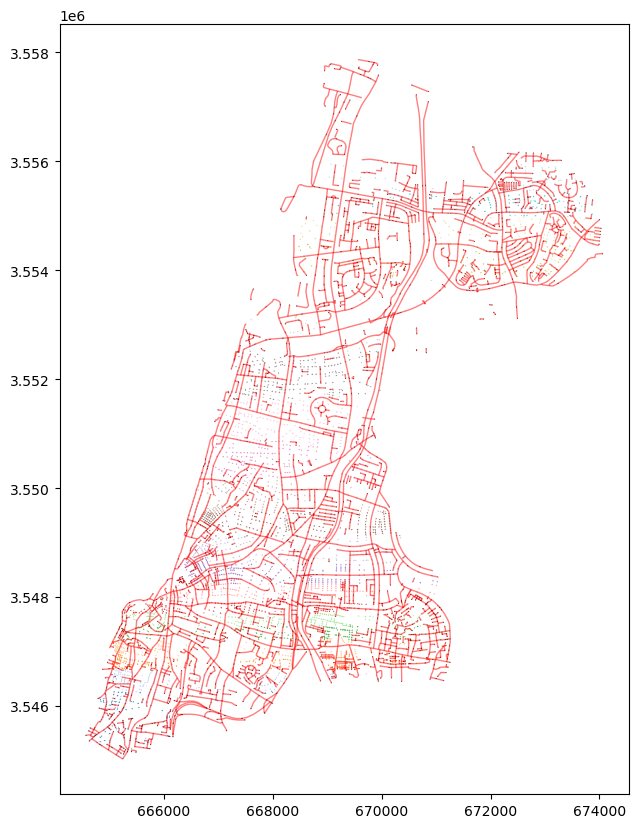

In [170]:
fig, ax = plt.subplots(figsize=(10,10))

# ta_streets[ta_streets.trechov == 'הולצברג שמחה'].plot(ax=ax, color='red')
ta_streets[ta_streets.trechov.isin(street_names)].plot(ax=ax, color='red',linewidth=1, alpha=0.5)

resulting_combined_polygons.plot(ax=ax, cmap='tab20')
# resulting_combined_polygons[resulting_combined_polygons.index == 0].plot(ax=ax, color='black')
resulting_combined_polygons[resulting_combined_polygons.num_trechov ==1].plot(ax=ax, color='black')

Seems OK to drop them

Checking crossroads with 3 street names

<Axes: >

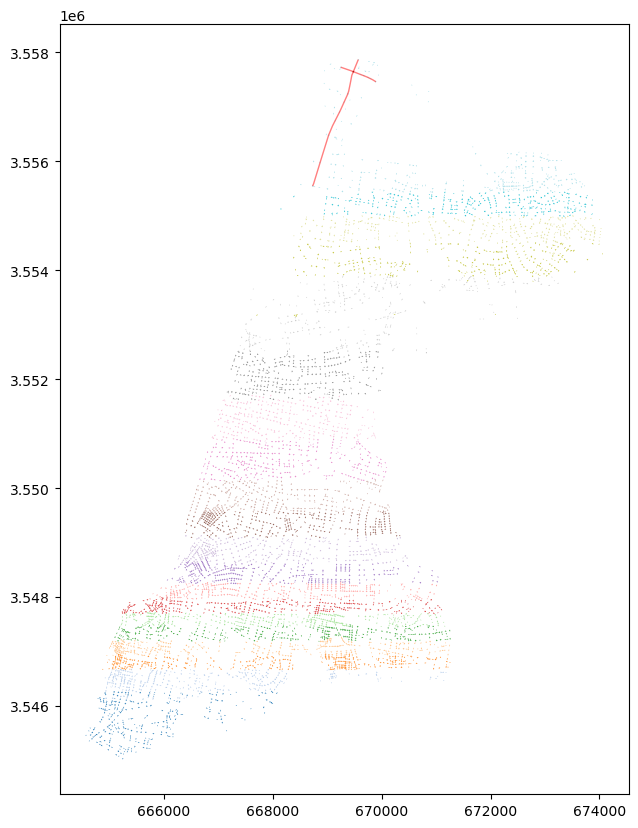

In [169]:

fig, ax = plt.subplots(figsize=(10,10))

# ta_streets[ta_streets.trechov == 'הולצברג שמחה'].plot(ax=ax, color='red')
ta_streets[ta_streets.trechov.isin(['2040', '2425',"יוניצ'מן" ])].plot(ax=ax, color='red',linewidth=1, alpha=0.5)

resulting_combined_polygons.plot(ax=ax, cmap='tab20')
# resulting_combined_polygons[resulting_combined_polygons.index == 0].plot(ax=ax, color='black')
# resulting_combined_polygons[resulting_combined_polygons.num_trechov ==1]
resulting_combined_polygons[resulting_combined_polygons.index == 5613].plot(ax=ax, color='black')


seems ok

In [56]:
crossroads = resulting_combined_polygons[resulting_combined_polygons.num_trechov > 1].copy()

crossroads

geometry  geo_length  \
0     POLYGON ((665251.028 3545022.970, 665250.991 3...   69.100794   
1     POLYGON ((665173.003 3545083.704, 665173.279 3...   51.403312   
2     POLYGON ((665136.784 3545100.508, 665137.185 3...   87.109020   
4     POLYGON ((665227.787 3545131.528, 665228.177 3...   82.956372   
9     POLYGON ((665173.472 3545168.918, 665177.786 3...  102.784069   
...                                                 ...         ...   
5610  POLYGON ((669682.957 3557574.183, 669683.404 3...   87.144049   
5613  POLYGON ((669487.620 3557650.166, 669492.204 3...  102.797975   
5614  POLYGON ((669775.071 3557641.033, 669775.064 3...   70.348862   
5617  POLYGON ((669253.043 3557722.800, 669251.421 3...   87.105175   
5627  POLYGON ((669567.411 3557871.865, 669567.505 3...   70.097456   

                   combined_trechov  num_trechov  
0           [ירושלים, הולצברג שמחה]            2  
1              [8186, הולצברג שמחה]            2  
2         [קרוא ברוך, הולצברג שמחה]            2  
4                [8186, מייזל זלמן]            2  
9           [קרוא ברוך, מייזל זלמן]            2  
...                             ...          ...  
5610  [זלצמן פנינה פרופ', יוניצ'מן]            2  
5613         [2040, יוניצ'מן, 2425]            3  
5614      [2379, זלצמן פנינה פרופ']            2  
5617               [2170, יוניצ'מן]            2  
5627                   [2379, 2425]            2  

[4157 rows x 4 columns]

In [57]:
crossroads_buff = crossroads.copy()
crossroads_buff['geometry'] = crossroads_buff.buffer(5)

In [58]:
crossroads_buff

geometry  geo_length  \
0     POLYGON ((665241.737 3545016.900, 665241.737 3...   69.100794   
1     POLYGON ((665168.735 3545086.310, 665168.868 3...   51.403312   
2     POLYGON ((665122.519 3545115.519, 665122.605 3...   87.109020   
4     POLYGON ((665214.302 3545122.601, 665214.204 3...   82.956372   
9     POLYGON ((665152.897 3545164.236, 665152.758 3...  102.784069   
...                                                 ...         ...   
5610  POLYGON ((669665.849 3557586.227, 669666.036 3...   87.144049   
5613  POLYGON ((669467.880 3557641.819, 669467.870 3...  102.797975   
5614  POLYGON ((669779.355 3557638.456, 669779.332 3...   70.348862   
5617  POLYGON ((669256.145 3557716.441, 669256.064 3...   87.105175   
5627  POLYGON ((669562.782 3557873.756, 669562.880 3...   70.097456   

                   combined_trechov  num_trechov  
0           [ירושלים, הולצברג שמחה]            2  
1              [8186, הולצברג שמחה]            2  
2         [קרוא ברוך, הולצברג שמחה]            2  
4                [8186, מייזל זלמן]            2  
9           [קרוא ברוך, מייזל זלמן]            2  
...                             ...          ...  
5610  [זלצמן פנינה פרופ', יוניצ'מן]            2  
5613         [2040, יוניצ'מן, 2425]            3  
5614      [2379, זלצמן פנינה פרופ']            2  
5617               [2170, יוניצ'מן]            2  
5627                   [2379, 2425]            2  

[4157 rows x 4 columns]

<Axes: >

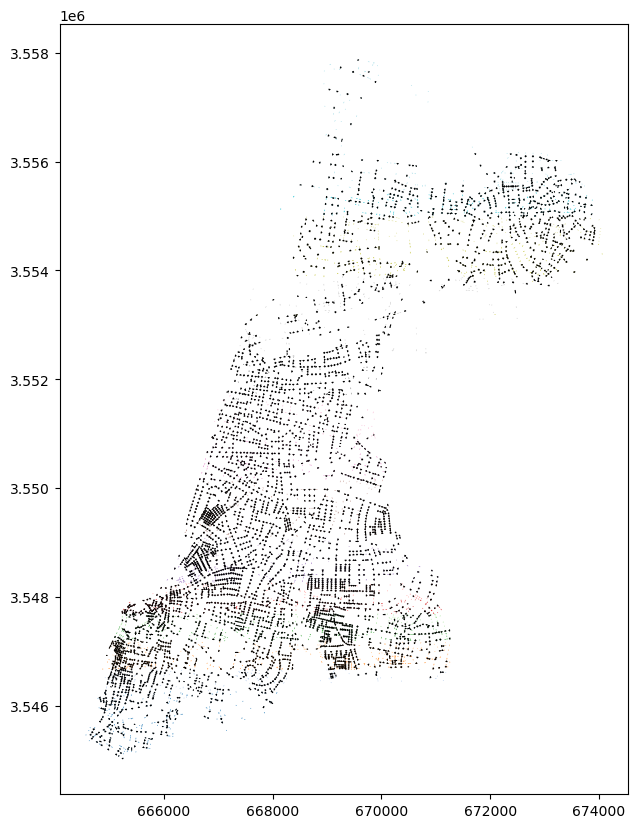

In [168]:

fig, ax = plt.subplots(figsize=(10,10))

# ta_streets[ta_streets.trechov == 'הולצברג שמחה'].plot(ax=ax, color='red')

resulting_combined_polygons.plot(ax=ax, cmap='tab20')
crossroads_buff.plot(ax=ax, color='black')


### NEXT: get all the accidents for each crossroad

In [60]:
i_m_h_ta_mm_acc_one_gdf = i_m_h_ta_mm_gdf[i_m_h_ta_mm_gdf.location_accuracy == 1 ].copy()
i_m_h_ta_mm_acc_one_gdf

accident_id  provider_and_id  provider_code  file_type_police  \
131      2013001350      12013001350              1                 1   
196      2013000147      12013000147              1                 1   
197      2013000147      12013000147              1                 1   
251      2013001755      32013001755              3                 3   
257      2013002105      32013002105              3                 3   
...             ...              ...            ...               ...   
111332   2024090432      12024090432              1                 1   
111345   2024096932      32024096932              3                 3   
111392   2024095225      32024095225              3                 3   
111394   2024095204      32024095204              3                 3   
111401   2024098057      12024098057              1                 1   

        involved_type involved_type_hebrew  license_acquiring_date  age_group  \
131                 2             נהג נפגע                       0          5   
196                 2             נהג נפגע                       0          8   
197                 2             נהג נפגע                       0          6   
251                 2             נהג נפגע                    2005          6   
257                 1                  נהג                       0          7   
...               ...                  ...                     ...        ...   
111332              2             נהג נפגע                    1996         10   
111345              2             נהג נפגע                    2023          4   
111392              2             נהג נפגע                    2019          5   
111394              2             נהג נפגע                    2013          7   
111401              2             נהג נפגע                    2018          7   

       age_group_hebrew  sex  ... vehicle_attribution  \
131               20-24    1  ...                 1.0   
196               35-39    1  ...                 1.0   
197               25-29    1  ...                 1.0   
251               25-29    1  ...                 1.0   
257               30-34    1  ...                 1.0   
...                 ...  ...  ...                 ...   
111332            45-49    2  ...                 1.0   
111345            15-19    1  ...                 1.0   
111392            20-24    1  ...                 1.0   
111394            30-34    1  ...                 1.0   
111401            30-34    1  ...                 1.0   

        vehicle_attribution_hebrew seats  total_weight total_weight_hebrew  \
131                         ישראלי  99.0           0.0             לא ידוע   
196                         ישראלי  99.0           0.0             לא ידוע   
197                         ישראלי  99.0           0.0             לא ידוע   
251                         ישראלי  99.0           0.0             לא ידוע   
257                         ישראלי  99.0           0.0             לא ידוע   
...                            ...   ...           ...                 ...   
111332                      ישראלי  99.0           0.0             לא ידוע   
111345                      ישראלי  99.0           0.0             לא ידוע   
111392                      ישראלי  99.0           0.0             לא ידוע   
111394                      ישראלי  99.0           0.0             לא ידוע   
111401                      ישראלי  99.0           0.0             לא ידוע   

        vehicle_damage vehicle_damage_hebrew  urban_intersection  \
131                4.0               אין נזק                 NaN   
196                2.0                בינוני           9110323.0   
197                2.0                בינוני           9110323.0   
251                4.0               אין נזק          11670545.0   
257                1.0                    קל           7540321.0   
...                ...                   ...                 ...   
111332             1.0                    קל          530400

Fixing *combined_trechov*

In [61]:
crossroads_buff['combined_trechov'] = crossroads_buff.combined_trechov.apply(lambda x: ','.join(x) )
crossroads_buff['combined_trechov']

0             ירושלים,הולצברג שמחה
1                8186,הולצברג שמחה
2           קרוא ברוך,הולצברג שמחה
4                  8186,מייזל זלמן
9             קרוא ברוך,מייזל זלמן
                   ...            
5610    זלצמן פנינה פרופ',יוניצ'מן
5613            2040,יוניצ'מן,2425
5614        2379,זלצמן פנינה פרופ'
5617                 2170,יוניצ'מן
5627                     2379,2425
Name: combined_trechov, Length: 4157, dtype: object

In [62]:
crossroads_buff.combined_trechov.value_counts().head(10)

combined_trechov
רבינא,רב אשי                       3
לבני איתן,0                        2
שוסטקוביץ' דמיטרי,אויסטרך דוד      2
גולי קניה,הגולן                    2
גורי ישראל,דשבסקי                  2
המדינה,הא באייר,ויצמן              2
שמגר,המצביאים                      2
כ.מוולפסון לצפון6200,חיל השריון    2
ראב"ד,שלמה                         2
ליוויק,אחרון יוסף                  2
Name: count, dtype: int64

<Axes: >

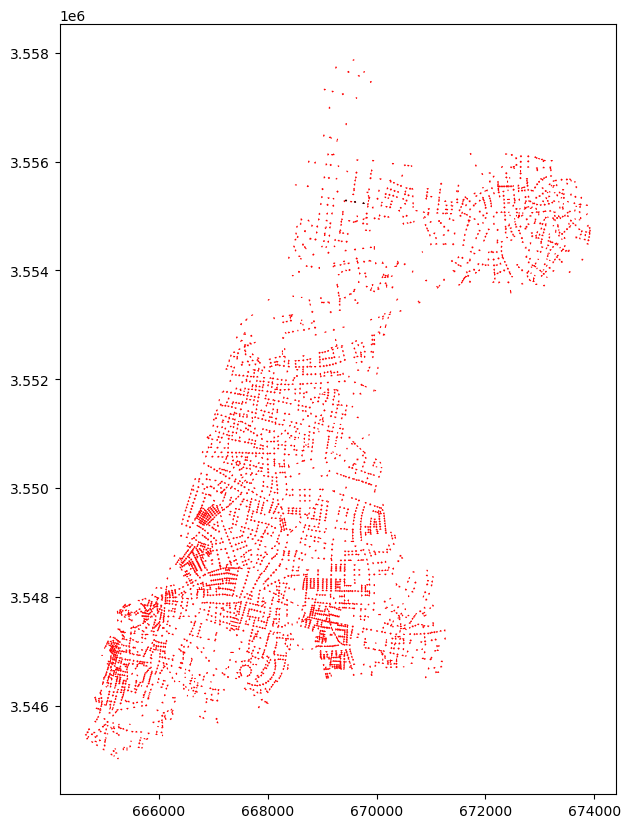

In [167]:
fig, ax = plt.subplots(figsize=(10,10))


crossroads_buff.plot(ax=ax, color='red')
crossroads_buff[crossroads_buff.combined_trechov == 'רבינא,רב אשי'].plot(ax=ax, color='black')

In [64]:
mm_accidents_in_crossroads = gpd.sjoin(i_m_h_ta_mm_acc_one_gdf,crossroads_buff, how='inner', predicate='intersects')
mm_accidents_in_crossroads

accident_id  provider_and_id  provider_code  file_type_police  \
196      2013000147      12013000147              1                 1   
197      2013000147      12013000147              1                 1   
251      2013001755      32013001755              3                 3   
257      2013002105      32013002105              3                 3   
349      2013001346      32013001346              3                 3   
...             ...              ...            ...               ...   
111269   2024098273      32024098273              3                 3   
111332   2024090432      12024090432              1                 1   
111345   2024096932      32024096932              3                 3   
111392   2024095225      32024095225              3                 3   
111394   2024095204      32024095204              3                 3   

        involved_type involved_type_hebrew  license_acquiring_date  age_group  \
196                 2             נהג נפגע                       0          8   
197                 2             נהג נפגע                       0          6   
251                 2             נהג נפגע                    2005          6   
257                 1                  נהג                       0          7   
349                 2             נהג נפגע                       0          5   
...               ...                  ...                     ...        ...   
111269              2             נהג נפגע                    1980         13   
111332              2             נהג נפגע                    1996         10   
111345              2             נהג נפגע                    2023          4   
111392              2             נהג נפגע                    2019          5   
111394              2             נהג נפגע                    2013          7   

       age_group_hebrew  sex  ... total_weight_hebrew  vehicle_damage  \
196               35-39    1  ...             לא ידוע             2.0   
197               25-29    1  ...             לא ידוע             2.0   
251               25-29    1  ...             לא ידוע             4.0   
257               30-34    1  ...             לא ידוע             1.0   
349               20-24    2  ...             לא ידוע             4.0   
...                 ...  ...  ...                 ...             ...   
111269            60-64    1  ...             לא ידוע             1.0   
111332            45-49    2  ...             לא ידוע             1.0   
111345            15-19    1  ...             לא ידוע             4.0   
111392            20-24    1  ...             לא ידוע             4.0   
111394            30-34    1  ...             לא ידוע             4.0   

       vehicle_damage_hebrew  urban_intersection        accident_date  \
196                   בינוני           9110323.0  2013-09-19 00:00:00   
197                   בינוני           9110323.0  2013-09-19 00:00:00   
251                  אין נזק          11670545.0  2013-11-23 01:30:00   
257                       קל           7540321.0  2013-01-01 02:15:00   
349                  אין נזק             10335.0  2013-09-06 01:00:00   
...                      ...                 ...                  ...   
111269                    קל          15270924.0  2024-03-31 08:00:00   
111332                    קל          53040001.0  2024-04-01 19:30:00   
111345               אין נזק                 NaN  2024-02-07 18:45:00   
111392               אין נזק                 NaN  2024-03-15 09:30:00   
111394               אין נזק          10960516.0  2024-05-05 14:00:00   

                              geometry index_right  geo_length  \
196     POINT (668158.751 3551284.678)        3802  102.584199   
197     POINT (668158.751 3551284.678)        3802  102.584199   
251     POINT (667291.113 3549059.667)        2789  102.796858   
257     POINT (667511.178 3551455.462)        3868  102.762023   
349     POINT (666916.964 3550924.250)        3669  101.353967   
...     

Plot for each year, that there are accidents the top crossroads.

In [65]:
crossroads_buff[crossroads_buff.combined_trechov.str.contains('קבוץ גלויות,איילון לכוון וולפסון')]

Empty GeoDataFrame
Columns: [geometry, geo_length, combined_trechov, num_trechov]
Index: []

In [164]:
# import leafmap
# m = leafmap.Map(center=(32.1, 34.8), zoom=12)
# m.add_gdf(crossroads_buff[crossroads_buff.combined_trechov.str.contains('קבוץ גלויות,איילון לכוון וולפסון')], layer_name="Streets", info_mode='on_hover', color='black')
# # m.add_gdf(crossroads_buff[crossroads_buff.combined_trechov.isin(crossroads_t10.index)], layer_name="Streets", info_mode='on_hover', color='black')

# m

In [165]:
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

# # Define the years and severities
# years = list(range(2013, 2024))  # Assuming years from 2013 to 2023
# severities = [1, 2, 3]  # Assuming severities: 1 = Killed, 2 = Seriously Injured, 3 = Lightly Injured

# # Create subplot titles
# subplot_titles = [
#     "All Years: All Severities",
#     "All Years: Killed",
#     "All Years: Seriously Injured",
#     "All Years: Lightly Injured",
# ]
# for year in years:
#     subplot_titles.extend(
#         [
#             f"{year}: All Severities",
#             f"{year}: Killed",
#             f"{year}: Seriously Injured",
#             f"{year}: Lightly Injured",
#         ]
#     )

# # Create a subplot layout with 2 rows: one for all years and one for each year
# fig = make_subplots(
#     rows=len(years) + 1, cols=4,  # First row for "All Years", subsequent rows for each year
#     subplot_titles=subplot_titles
# )

# # Row 1: Aggregated data across all years
# crossroads_all_years = (
#     mm_accidents_in_crossroads['combined_trechov']
#     .value_counts()
#     .head(10)
# )
# fig.add_trace(
#     go.Bar(
#         x=crossroads_all_years.index,
#         y=crossroads_all_years.values,
#         text=crossroads_all_years.values,
#         textposition='outside',
#         name="All Severities"
#     ),
#     row=1, col=1
# )

# for i, severity in enumerate(severities, start=2):
#     crossroads_severity_all_years = (
#         mm_accidents_in_crossroads[
#             mm_accidents_in_crossroads.accident_severity == severity
#         ]['combined_trechov']
#         .value_counts()
#         .head(10)
#     )
#     fig.add_trace(
#         go.Bar(
#             x=crossroads_severity_all_years.index,
#             y=crossroads_severity_all_years.values,
#             text=crossroads_severity_all_years.values,
#             textposition='outside',
#             name=f"Severity {severity}"
#         ),
#         row=1, col=i
#     )

# # Rows 2 to n+1: Data for each year
# for row_idx, year in enumerate(years, start=2):  # Start at row 2 for years
#     # Plot 1: All severities for the year
#     crossroads_all = (
#         mm_accidents_in_crossroads[mm_accidents_in_crossroads.accident_year == year]['combined_trechov']
#         .value_counts()
#         .head(10)
#     )
#     fig.add_trace(
#         go.Bar(
#             x=crossroads_all.index,
#             y=crossroads_all.values,
#             text=crossroads_all.values,
#             textposition='outside',
#             name="All Severities"
#         ),
#         row=row_idx, col=1
#     )
    
#     # Plot 2 to 4: Severity levels 1, 2, and 3 for the year
#     for col_idx, severity in enumerate(severities, start=2):  # Start at column 2 for severities
#         crossroads_severity = (
#             mm_accidents_in_crossroads[
#                 (mm_accidents_in_crossroads.accident_year == year) &
#                 (mm_accidents_in_crossroads.accident_severity == severity)
#             ]['combined_trechov']
#             .value_counts()
#             .head(10)
#         )
#         fig.add_trace(
#             go.Bar(
#                 x=crossroads_severity.index,
#                 y=crossroads_severity.values,
#                 text=crossroads_severity.values,
#                 textposition='outside',
#                 name=f"Severity {severity}"
#             ),
#             row=row_idx, col=col_idx
#         )

# # Update layout for better visualization
# fig.update_layout(
#     title_text="Tel Aviv Most Dangerous Crossroads by Severity and Year",
#     height=600 * (len(years) + 1),  # Adjust height dynamically
#     width=1500,  # Adjust width for all columns
#     showlegend=False,  # Disable legend to save space
#     template="plotly_white",
# )

# # Loop through all subplots to set the tickangle for x-axis
# for row_idx in range(1, len(years) + 2):  # Rows: 1 for all years + len(years)
#     for col_idx in range(1, 5):  # Columns: 4 subplots per row
#         fig.update_xaxes(
#             tickangle=-45,  # Tilt x-axis labels
#             row=row_idx,
#             col=col_idx
#         )

# # Show the plot
# fig.show()


What street segments have the most accidents

In [68]:
ta_streets_buff = ta_streets.copy()

ta_streets_buff['geometry'] = ta_streets_buff.geometry.buffer(10)
ta_streets_buff['geometry'] 

0       POLYGON ((672899.692 3554089.512, 672900.547 3...
1       POLYGON ((667066.715 3551436.436, 667067.679 3...
2       POLYGON ((667943.386 3551417.067, 667944.319 3...
3       POLYGON ((669572.412 3550448.271, 669572.884 3...
4       POLYGON ((669409.578 3548331.348, 669410.558 3...
                              ...                        
8874    POLYGON ((665769.455 3546992.131, 665769.026 3...
8875    POLYGON ((665634.457 3547148.186, 665701.636 3...
8876    POLYGON ((665763.770 3547037.782, 665775.942 3...
8877    POLYGON ((665073.353 3546669.392, 665072.374 3...
8878    POLYGON ((666928.732 3548303.793, 666958.846 3...
Name: geometry, Length: 8879, dtype: geometry

In [69]:
streets_with_accidents = gpd.sjoin(i_m_h_ta_mm_acc_one_gdf, ta_streets_buff, how='inner',predicate='intersects')
streets_with_accidents

accident_id  provider_and_id  provider_code  file_type_police  \
196      2013000147      12013000147              1                 1   
197      2013000147      12013000147              1                 1   
251      2013001755      32013001755              3                 3   
251      2013001755      32013001755              3                 3   
251      2013001755      32013001755              3                 3   
...             ...              ...            ...               ...   
111394   2024095204      32024095204              3                 3   
111394   2024095204      32024095204              3                 3   
111394   2024095204      32024095204              3                 3   
111394   2024095204      32024095204              3                 3   
111401   2024098057      12024098057              1                 1   

        involved_type involved_type_hebrew  license_acquiring_date  age_group  \
196                 2             נהג נפגע                       0          8   
197                 2             נהג נפגע                       0          6   
251                 2             נהג נפגע                    2005          6   
251                 2             נהג נפגע                    2005          6   
251                 2             נהג נפגע                    2005          6   
...               ...                  ...                     ...        ...   
111394              2             נהג נפגע                    2013          7   
111394              2             נהג נפגע                    2013          7   
111394              2             נהג נפגע                    2013          7   
111394              2             נהג נפגע                    2013          7   
111401              2             נהג נפגע                    2018          7   

       age_group_hebrew  sex  ... oidrechov  krechov     trechov   shemangli  \
196               35-39    1  ...     737.0    496.0  אבן גבירול  IBN GVIROL   
197               25-29    1  ...     737.0    496.0  אבן גבירול  IBN GVIROL   
251               25-29    1  ...    1196.0      4.0       אלנבי     ALLENBY   
251               25-29    1  ...    4445.0     10.0  מונטיפיורי  MONTEFIORE   
251               25-29    1  ...    4446.0     10.0  מונטיפיורי  MONTEFIORE   
...                 ...  ...  ...       ...      ...         ...         ...   
111394            30-34    1  ...    7287.0     11.0     אחד העם  AHAD HA'AM   
111394            30-34    1  ...    4058.0    358.0     בר אילן    BAR ILAN   
111394            30-34    1  ...    1319.0    358.0     בר אילן    BAR ILAN   
111394            30-34    1  ...    7286.0     11.0     אחד העם  AHAD HA'AM   
111401            30-34    1  ...    7666.0    476.0      קרליבך   KARLIBACH   

       mslamas  tsug kkivun   UniqueId      shemarvit  kreka  
196     1040.0  רחוב    0.0  507-10863     حجر غفيرول  200.0  
197     1040.0  רחוב    0.0  507-10863     حجر غفيرول  200.0  
251     1135.0  רחוב    1.0  507-11355         ألينبي  200.0  
251     1255.0  רחוב    2.0  507-15164      مونتيفيور  100.0  
251     1255.0  רחוב    2.0  507-15165      مونتيفيور  100.0  
...        ...   ...    ...        ...            ...    ...  
111394  1104.0  רחוב    1.0  507-18853  واحد من الناس  100.0  
111394  1109.0  רחוב    1.0  507-14742      بار إيلان  100.0  
111394  1109.0  רחוב    1.0  507-11487      بار إيلان  100.0  
111394  1104.0  רחוב    1.0  507-18852  واحد من الناس  100.0  
111401  1511.0  רחוב    0.0  507-18088        كارلباخ  100.0  

[8221 rows x 173 columns]

Remove overlapping accidents in streets by removing accidents that are also in mm_accidents_in_crossroads

In [70]:
streets_with_accidents_idx     = streets_with_accidents.index
mm_accidents_in_crossroads_idx = mm_accidents_in_crossroads.index

accidents_only_on_streets_idx = np.setdiff1d(streets_with_accidents_idx,mm_accidents_in_crossroads_idx)


streets_with_accidents_no_crossroads= streets_with_accidents.loc[accidents_only_on_streets_idx]
streets_with_accidents_no_crossroads


accident_id  provider_and_id  provider_code  file_type_police  \
455      2013002036      12013002036              1                 1   
543      2013000191      12013000191              1                 1   
593      2013000876      12013000876              1                 1   
598      2013003864      32013003864              3                 3   
639      2013003874      12013003874              1                 1   
...             ...              ...            ...               ...   
111275   2024093992      32024093992              3                 3   
111291   2024094789      32024094789              3                 3   
111304   2024091837      32024091837              3                 3   
111326   2024098833      32024098833              3                 3   
111401   2024098057      12024098057              1                 1   

        involved_type involved_type_hebrew  license_acquiring_date  age_group  \
455                 2             נהג נפגע                       0          6   
543                 2             נהג נפגע                       0         12   
593                 2             נהג נפגע                       0          7   
598                 2             נהג נפגע                       0          8   
639                 2             נהג נפגע                       0         11   
...               ...                  ...                     ...        ...   
111275              2             נהג נפגע                       0          7   
111291              2             נהג נפגע                    2017          6   
111304              2             נהג נפגע                    2018          6   
111326              1                  נהג                       0         99   
111401              2             נהג נפגע                    2018          7   

       age_group_hebrew  sex  ... oidrechov  krechov         trechov  \
455               25-29    2  ...     604.0     25.0        בן יהודה   
543               55-59    1  ...    8998.0   3311.0     קבוץ גלויות   
593               30-34    1  ...    1887.0      2.0            הרצל   
598               35-39    1  ...    3322.0    842.0            צה"ל   
639               50-54    1  ...     165.0   2141.0    בן יוסף שלמה   
...                 ...  ...  ...       ...      ...             ...   
111275            30-34    1  ...    1394.0    475.0           המסגר   
111291            25-29    2  ...    1783.0   3557.0        אבולעפיה   
111304            25-29    1  ...    1357.0   2237.0  מוזס יהודה ונח   
111326          לא ידוע    0  ...    4982.0   1007.0          הפלמ"ח   
111401            30-34    1  ...    7666.0    476.0          קרליבך   

               shemangli mslamas  tsug kkivun   UniqueId  \
455           BEN-YEHUDA   510.0  רחוב    1.0  507-10725   
543      Kibbuts Galuiot  2309.0   דרך    0.0  507-12123   
593                HERZL  2215.0  רחוב    0.0  507-12195   
598               TSAHAL   301.0  רחוב    1.0  507-13883   
639            BEN YOSEF   282.0  רחוב    0.0  507-10211   
...                  ...     ...   ...    ...        ...   
111275          HAMASGER  1554.0  רחוב    0.0  507-11578   
111291  CYAYIN ABUL'AFIA  1632.0  רחוב    1.0  507-12044   
111304             MOZES  2572.0  רחוב    0.0  507-11531   
111326          HAPALMAH  2644.0  רחוב    2.0  507-15779   
111401         KARLIBACH  1511.0  רחוב    0.0  507-18088   

                     shemarvit  kreka  
455                   بن يهودا  200.0  
543     بطاقات بريدية Kabbalah  200.0  
593                      هرتسل  200.0  
598                        IDF  100.0  
639              بن يوسف شلومو  100.0  
...                        ...    ...  
111275                 الأقفال  100.0  
111291                Abulafia  100.0  
111304         موسى يهودا ونوح  100.0  
111326                   بالاش  100.0  
111401                 كارلباخ  100.0  

[1998 rows x 173 columns]

In [166]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # Define the years and severity levels
# years = list(range(2013, 2024))  # Assuming years from 2013 to 2023
# severities = [1, 2, 3]  # Assuming severities: 1 = Killed, 2 = Seriously Injured, 3 = Lightly Injured

# # Create subplot titles
# subplot_titles = [
#     "All Years: All Severities",
#     "All Years: Killed",
#     "All Years: Seriously Injured",
#     "All Years: Lightly Injured",
# ]
# for year in years:
#     subplot_titles.extend(
#         [
#             f"{year}: All Severities",
#             f"{year}: Killed",
#             f"{year}: Seriously Injured",
#             f"{year}: Lightly Injured",
#         ]
#     )

# # Create a subplot layout
# fig = make_subplots(
#     rows=len(years) + 1, cols=4,  # First row for "All Years", subsequent rows for each year
#     subplot_titles=subplot_titles
# )

# # Row 1: Aggregated data across all years
# streets_all_years = (
#     streets_with_accidents_no_crossroads['trechov']
#     .value_counts()
#     .head(10)
# )
# fig.add_trace(
#     go.Bar(
#         x=streets_all_years.index,
#         y=streets_all_years.values,
#         text=streets_all_years.values,
#         textposition='outside',
#         name="All Severities"
#     ),
#     row=1, col=1
# )

# for i, severity in enumerate(severities, start=2):
#     streets_severity_all_years = (
#         streets_with_accidents_no_crossroads[
#             streets_with_accidents_no_crossroads.accident_severity == severity
#         ]['trechov']
#         .value_counts()
#         .head(10)
#     )
#     fig.add_trace(
#         go.Bar(
#             x=streets_severity_all_years.index,
#             y=streets_severity_all_years.values,
#             text=streets_severity_all_years.values,
#             textposition='outside',
#             name=f"Severity {severity}"
#         ),
#         row=1, col=i
#     )

# # Rows 2 to n+1: Data for each year
# for row_idx, year in enumerate(years, start=2):
#     # Plot 1: All severities for the year
#     t10_streets_by_accidents = (
#         streets_with_accidents_no_crossroads[streets_with_accidents_no_crossroads.accident_year == year]['trechov']
#         .value_counts()
#         .head(10)
#     )
#     fig.add_trace(
#         go.Bar(
#             x=t10_streets_by_accidents.index,
#             y=t10_streets_by_accidents.values,
#             text=t10_streets_by_accidents.values,
#             textposition='outside',
#             name="All Severities"
#         ),
#         row=row_idx, col=1
#     )
    
#     # Plot 2 to 4: Severity levels 1, 2, and 3 for the year
#     for col_idx, severity in enumerate(severities, start=2):
#         t10_streets_by_accidents_and_severity = (
#             streets_with_accidents_no_crossroads[
#                 (streets_with_accidents_no_crossroads.accident_year == year) &
#                 (streets_with_accidents_no_crossroads.accident_severity == severity)
#             ]['trechov']
#             .value_counts()
#             .head(10)
#         )
#         fig.add_trace(
#             go.Bar(
#                 x=t10_streets_by_accidents_and_severity.index,
#                 y=t10_streets_by_accidents_and_severity.values,
#                 text=t10_streets_by_accidents_and_severity.values,
#                 textposition='outside',
#                 name=f"Severity {severity}"
#             ),
#             row=row_idx, col=col_idx
#         )

# # Update layout for better visualization
# fig.update_layout(
#     title_text="Tel Aviv Most Dangerous Streets by Severity and Year",
#     height=600 * (len(years) + 1),  # Adjust height dynamically
#     width=1300,  # Adjust width for all columns
#     showlegend=False,  # Disable legend to save space
#     template="plotly_white",
# )

# # Loop through all subplots to tilt x-axis labels
# for row_idx in range(1, len(years) + 2):  # Rows: 1 for all years + len(years)
#     for col_idx in range(1, 5):  # Columns: 4 subplots per row
#         fig.update_xaxes(
#             tickangle=-45,  # Tilt x-axis labels
#             row=row_idx,
#             col=col_idx
#         )

# # Show the plot
# fig.show()


### Checking crossroads that have taken unrelated roads

In [72]:
# First check crossroads with the most streets.
crossroads_buff.num_trechov.sort_values().tail(50)

2212     5
1027     5
1836     5
902      5
2497     5
3203     5
3057     5
5540     5
2830     5
1717     5
2956     5
4825     5
600      5
966      5
1899     5
1003     5
2081     5
3088     5
4838     5
5410     5
1379     5
660      5
4246     5
2473     5
592      5
3629     5
797      5
1896     5
1951     5
1799     5
1655     6
2073     6
1849     6
1677     6
2644     6
1369     6
1113     6
1632     6
881      6
1619     6
394      6
1470     7
1698     7
1107     7
733      7
1121     7
1436     8
978      8
2466     9
2508    10
Name: num_trechov, dtype: int64

In [73]:
orig_cross_with_created_cross = gpd.sjoin(ta_crossroads_from_streets, crossroads_buff[['combined_trechov','geometry','num_trechov']])

orig_idx_to_check = orig_cross_with_created_cross[orig_cross_with_created_cross.combined_trechov.str.contains('קבוץ גלויות,8161,איילון')].index
orig_idx_to_check

Index([], dtype='int64')

In [74]:
# import leafmap
# m = leafmap.Map(center=(32.047, 34.785), zoom=11)
# # m.add_gdf(crossroads_buff[crossroads_buff.combined_trechov.str.contains('קבוץ גלויות,איילון לכוון וולפסון')], layer_name="Streets", fill_colors='black', zoom_to_layer=True)
# # m.add_gdf(orig_cross_with_created_cross[orig_cross_with_created_cross.combined_trechov.str.contains('קבוץ גלויות,איילון לכוון וולפסון')], layer_name="Streets", fill_colors='black', zoom_to_layer=True)
# m.add_gdf(ta_crossroads_from_streets.loc[orig_idx_to_check], layer_name="crossroad_to_check", fill_colors='black', zoom_to_layer=True)
# # m.add_gdf(ta_streets, layer_name="Streets", fill_colors='black',)
# # m.add_gdf(ta_crossroads, layer_name="Streets", fill_colors='black',)

# m

We see issues with our map, "קיבוץ גלויות" is a two way street but only one line string, when connecting to other streets it creates a connection that is missing the real street connections.

Hence the crossroads are misaligned. 

---

Trying Open Street Map

In [75]:
import networkx as nx
import osmnx as ox

In [76]:
G = ox.graph_from_place("Tel Aviv, Israel", network_type="drive")

In [77]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes = gdf_nodes.to_crs('32636')
gdf_edges = gdf_edges.to_crs('32636')
gdf_nodes.head()

y          x          highway  street_count  ref  \
osmid                                                              
139693  32.093840  34.790572  traffic_signals             4  NaN   
139698  32.093869  34.791231              NaN             3  NaN   
139707  32.095354  34.778500              NaN             3  NaN   
139708  32.095052  34.778329              NaN             3  NaN   
139709  32.094527  34.778842              NaN             4  NaN   

                              geometry  
osmid                                   
139693  POINT (668968.683 3552240.237)  
139698  POINT (669030.815 3552244.552)  
139707  POINT (667826.578 3552389.242)  
139708  POINT (667810.983 3552355.494)  
139709  POINT (667860.387 3552298.098)

In [163]:
# fig, ax = plt.subplots(figsize=(20,20))

# gdf_edges.plot(ax=ax, color='black')

So after viewing the data from Open Street Map, it seems very well made.

When exploring further I found there are roads with no name (nan).<br>
It presents a challenge what to call them, in general these are roads that connect between streets.

**Potential problems:**

**Naming:** naming should be "street1 connects to street2".<br>
A potential issue is how to tell which streets connect to the other.<br>
One idea is to treat them as a right turn, if they are a right turn then we can use the street curve to determine where which street are connecting to which.

**roundabouts:** problem arises when looking at roundabouts, sometimes there is a road between to an entry road and an exist road, looking at the right turn will not help us get it's name.
**Solution:** Maybe roundabout should be treated as a whole, get all the roundabout connected them to a single polygon and connect with the streets that connect them.

**Tunnels:** they pass under other streets so when finding accidents it might assign an accident from the street above
**Solution** check the name of the street to make sure to assign the accident properly.

**Wrong crossroads:** the top blue circle, a crossroad, isn't an actual crossroad, it actually going under the street the crossroad is shown.
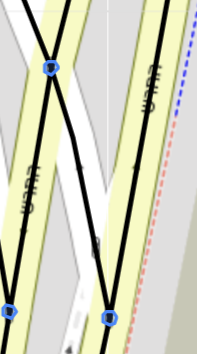

Found out there are some street that it is possible to turn left to them, maybe they have a traffic signal(stop light)

AND NO, there can be right turn with a traffic signal (from איילון to זבוטינסקי)


#### **DECISiON:** when creating crossroads where street1 is known but street2 in nan we will take street 2 and find where it's end point touches another street.<br>
The name will be "street1 connector(road with nan) street2(end point touches another street)"

---

Trying another idea, take the start point in all na roads turn to a polygon and check on the map does it corresponds to actual beginning of the road if it is we can use the end point to get the name of street2.

IT WORKS!

We will use the fact that a start point indicates the direction, so a road that connect between hashalom and alenbi that has a start point at alenbi.<br>
It's direction is alenbi to hashalom 



### Plan:
I am going to recreate the crossroads.

The general plan:
1. [X] take roundabouts and turn them to a single line
2. [X] give edges with names that are nan a name
3. [X] return unnamed roads
4. [X] split the roads in half like I did previously with **split_linestrings_by_length**
5. [X] Drop duplicates
6. [X] merge crossroads_ox with roundabout_with_info

In [79]:
gdf_edges.junction.value_counts()

junction
roundabout    505
circular        3
Name: count, dtype: int64

In [80]:
gdf_edges[gdf_edges['junction'] == 'circular']

osmid  oneway  \
u          v          key                                                
412519847  9399427381 0                [229938809, 1019049227]    True   
2144024859 412520369  0    [1134725835, 1019049228, 204856710]    True   
9399427381 2541845407 0                [247269138, 1019049227]    True   

                                                            name   highway  \
u          v          key                                                    
412519847  9399427381 0           [כיכר דיזנגוף (צינה), דיזנגוף]  tertiary   
2144024859 412520369  0    [כיכר דיזנגוף (צינה), דיזנגוף, ריינס]  tertiary   
9399427381 2541845407 0           [דיזנגוף, כיכר דיזנגוף (צינה)]  tertiary   

                          reversed   length  \
u          v          key                     
412519847  9399427381 0      False  154.641   
2144024859 412520369  0      False  265.489   
9399427381 2541845407 0      False  126.558   

                                                                    geometry  \
u          v          key                                                      
412519847  9399427381 0    LINESTRING (667427.049 3550580.488, 667438.054...   
2144024859 412520369  0    LINESTRING (667483.719 3550338.312, 667481.273...   
9399427381 2541845407 0    LINESTRING (667421.693 3550437.088, 667426.951...   

                          maxspeed lanes  ref access tunnel bridge  junction  \
u          v          key                                                      
412519847  9399427381 0        NaN     2  NaN    NaN    NaN    NaN  circular   
2144024859 412520369  0        NaN     1  NaN    NaN    NaN    NaN  circular   
9399427381 2541845407 0        NaN   NaN  NaN    NaN    NaN    NaN  circular   

                          width  
u          v          key        
412519847  9399427381 0     NaN  
2144024859 412520369  0     NaN  
9399427381 2541845407 0     NaN

### take roundabouts and turn them to a single line

In [81]:
# Step 1: Buffer and create roundabout polygons
roundabouts = gdf_edges[gdf_edges.junction == 'roundabout'].copy()
roundabouts['geometry'] = roundabouts.buffer(1)
roundabouts_geometry = unary_union(roundabouts.geometry)

# Create polygons GeoDataFrame
roundabouts_poly = gpd.GeoDataFrame(geometry=[roundabouts_geometry], crs=roundabouts.crs)
roundabouts_poly = roundabouts_poly.explode(index_parts=True).reset_index(drop=True)

# Step 2: Assign unique IDs to roundabout polygons
roundabouts_poly['poly_id'] = roundabouts_poly.index

# Step 3: Spatial join to associate edges with polygons
edges_with_polygons = gpd.sjoin(roundabouts, roundabouts_poly, how='inner', predicate='intersects')

# Step 4: Analyze or group information
# Example: For each polygon, find the first edge's data
roundabouts_with_info = (
    edges_with_polygons.groupby('poly_id')
    .first()  # Select the first edge information for each polygon
    .reset_index()
)

# View the resulting dataframe
roundabouts_with_info['geometry'] = roundabouts_poly.geometry
roundabouts_with_info


poly_id       osmid  oneway  name      highway reversed  length  \
0          0   159555091    True  None     tertiary    False   1.317   
1          1   742719147    True  None     tertiary    False  20.654   
2          2   113140773    True  None     tertiary    False  10.751   
3          3   925514478    True  None  residential    False  16.055   
4          4   132638933    True  None  residential    False  37.276   
..       ...         ...     ...   ...          ...      ...     ...   
108      108    31651913    True  None     tertiary    False  18.347   
109      109    35373026    True  None  residential    False  43.276   
110      110    31651960    True  None  residential    False   8.331   
111      111  1173903897    True  None  residential    False  14.612   
112      112  1173228630    True  None  residential    False  15.313   

                                              geometry maxspeed lanes   ref  \
0    POLYGON ((664987.697 3545203.066, 664987.712 3...     None  None  None   
1    POLYGON ((665604.642 3545525.137, 665604.651 3...     None  None  None   
2    POLYGON ((664907.429 3545553.230, 664907.423 3...     None  None  None   
3    POLYGON ((665187.533 3545578.514, 665187.541 3...     None  None  None   
4    POLYGON ((666387.375 3545959.283, 666387.370 3...     None  None  None   
..                                                 ...      ...   ...   ...   
108  POLYGON ((669094.360 3555949.980, 669094.355 3...     None  None  None   
109  POLYGON ((670006.499 3556007.037, 670006.499 3...     None  None  None   
110  POLYGON ((669111.898 3556123.751, 669111.871 3...     None  None  None   
111  POLYGON ((669623.940 3557159.025, 669623.936 3...     None  None  None   
112  POLYGON ((669257.048 3557723.161, 669257.041 3...     None  None  None   

    access tunnel bridge    junction width  index_right  
0     None   None   None  roundabout  None            0  
1     None   None   None  roundabout  None            1  
2     None   None   None  roundabout  None            2  
3     None   None   None  roundabout  None            3  
4     None   None   None  roundabout  None            4  
..     ...    ...    ...         ...   ...          ...  
108   None   None   None  roundabout  None          108  
109   None   None   None  roundabout  None          109  
110   None   None   None  roundabout  None          110  
111   None   None   None  roundabout  None          111  
112   None   None   None  roundabout  None          112  

[113 rows x 17 columns]

### give edges with nan names a proper name

In [82]:
# Step 1: Filter edges with no name
unnamed_roads = gdf_edges[gdf_edges.name.isna()].copy()

In [83]:
import osmnx as ox
from shapely.geometry import Point

# Ensure CRS is consistent between GeoDataFrames

# Step 1: Extract start and end points from each LineString in 'unnamed_roads'
def get_start_and_end_points(line):
    return line.coords[0], line.coords[-1]

unnamed_roads['start_point'], unnamed_roads['end_point'] = zip(*unnamed_roads['geometry'].apply(get_start_and_end_points))

# Step 2: Convert start and end points to shapely Points
unnamed_roads['start_point'] = unnamed_roads['start_point'].apply(lambda x: Point(x))
unnamed_roads['end_point'] = unnamed_roads['end_point'].apply(lambda x: Point(x))

# Step 3: Find the closest edge in `ta_streets` for each point
def find_closest_edge(point, ta_streets):
    # Find the nearest edge and return its index
    edge_idx = ta_streets.distance(point).idxmin()
    return edge_idx

unnamed_roads['start_edge_idx'] = unnamed_roads['start_point'].apply(find_closest_edge, ta_streets=ta_streets)
unnamed_roads['end_edge_idx'] = unnamed_roads['end_point'].apply(find_closest_edge, ta_streets=ta_streets)

# Step 4: Retrieve the 'trechov' value of the closest edges
unnamed_roads['start_trechov'] = unnamed_roads['start_edge_idx'].apply(lambda idx: ta_streets.loc[idx, 'trechov'])
unnamed_roads['end_trechov'] = unnamed_roads['end_edge_idx'].apply(lambda idx: ta_streets.loc[idx, 'trechov'])

# Step 5: Assign the new name based on the trechov values
# Optionally combine both start and end names or use one
unnamed_roads['new_name'] = unnamed_roads['start_trechov']  # Use start trechov value as an example

# Final result
unnamed_roads[['new_name']]


new_name
u           v           key                   
1226885     2989957353  0         גבעת התחמושת
1227320     2473987496  0           אבן גבירול
1228104     442898687   0                השלום
1228344     2481705198  0           בר-לב חיים
1329714     17703741    0                השלום
...                                        ...
12120460101 12120460109 0    זלצמן פנינה פרופ'
12120460109 12120455200 0    זלצמן פנינה פרופ'
            9931532351  0    זלצמן פנינה פרופ'
12287814424 2213119636  0     נתיבי אילון דרום
12361383714 2108063253  0                 אילת

[1295 rows x 1 columns]

In [84]:
def get_new_name(row):
    start_name = row['start_trechov']
    end_name = row['end_trechov']

    # Unicode marks for RTL and LTR handling
    RLM = '\u200F'  # Right-to-Left Mark
    LRM = '\u200E'  # Left-to-Right Mark

    if start_name == end_name:
        return RLM + start_name  # Apply RLM to enforce correct order

    # Combine names with RLM for proper display
    combined_name = f"{RLM}{start_name} ל {RLM}{end_name}"
    return combined_name


In [85]:
unnamed_roads['new_name'] = unnamed_roads.apply( get_new_name, axis=1)

In [86]:
unnamed_roads_mask = unnamed_roads.index

gdf_edges.loc[unnamed_roads_mask,'name'] = unnamed_roads['new_name']
gdf_edges.loc[unnamed_roads_mask,'name']

u            v            key
1226885      2989957353   0      ‏גבעת התחמושת ל ‏נתיבי אילון דרום
1227320      2473987496   0                            ‏אבן גבירול
1228104      442898687    0                     ‏השלום ל ‏דיין משה
1228344      2481705198   0                ‏בר-לב חיים ל ‏דיין משה
1329714      17703741     0                   ‏השלום ל ‏עלית הנוער
                                               ...                
12120460101  12120460109  0                     ‏זלצמן פנינה פרופ'
12120460109  12120455200  0         ‏זלצמן פנינה פרופ' ל ‏יוניצ'מן
             9931532351   0             ‏זלצמן פנינה פרופ' ל ‏2379
12287814424  2213119636   0                      ‏נתיבי אילון דרום
12361383714  2108063253   0                    ‏אילת ל ‏הרבי מבכרך
Name: name, Length: 1295, dtype: object

### return unnamed roads

In [87]:
gdf_nodes_buff = gdf_nodes.copy()
gdf_nodes_buff['geometry'] = gdf_nodes_buff.buffer(1)

### split the roads in half like I did previously with **split_linestrings_by_length**

In [88]:
gdf_edges_no_roundabout = gdf_edges[~(gdf_edges.junction == 'roundabout')].copy()

In [89]:
gdf_edges_no_roundabout_split = split_linestrings_by_length(gdf_edges_no_roundabout)
gdf_edges_no_roundabout_split.head()


osmid  oneway         name      highway reversed   length  \
0  167691710    True  יהודה המכבי     tertiary    False   62.173   
1  167691710    True  יהודה המכבי     tertiary    False   62.173   
2  167691710    True  יהודה המכבי     tertiary    False  110.029   
3  167691710    True  יהודה המכבי     tertiary    False  110.029   
4   26516058   False       ירמיהו  residential    False   37.249   

                                            geometry maxspeed lanes  ref  \
0  LINESTRING (668968.683 3552240.237, 668978.671...      NaN   NaN  NaN   
1  LINESTRING (669020.844 3552243.787, 669030.815...      NaN   NaN  NaN   
2  LINESTRING (669030.815 3552244.552, 669040.771...      NaN   NaN  NaN   
3  LINESTRING (669130.394 3552255.903, 669140.303...      NaN   NaN  NaN   
4  LINESTRING (667826.578 3552389.242, 667822.383...      NaN   NaN  NaN   

  access tunnel bridge junction width  
0    NaN    NaN    NaN      NaN   NaN  
1    NaN    NaN    NaN      NaN   NaN  
2    NaN    NaN    NaN      NaN   NaN  
3    NaN    NaN    NaN      NaN   NaN  
4    NaN    NaN    NaN      NaN   NaN

In [90]:
gdf_edges_no_roundabout_split['name_type'] = gdf_edges_no_roundabout_split.name.apply(type)
gdf_edges_no_roundabout_split[gdf_edges_no_roundabout_split['name_type'] != list].head()

osmid  oneway         name      highway reversed   length  \
0  167691710    True  יהודה המכבי     tertiary    False   62.173   
1  167691710    True  יהודה המכבי     tertiary    False   62.173   
2  167691710    True  יהודה המכבי     tertiary    False  110.029   
3  167691710    True  יהודה המכבי     tertiary    False  110.029   
4   26516058   False       ירמיהו  residential    False   37.249   

                                            geometry maxspeed lanes  ref  \
0  LINESTRING (668968.683 3552240.237, 668978.671...      NaN   NaN  NaN   
1  LINESTRING (669020.844 3552243.787, 669030.815...      NaN   NaN  NaN   
2  LINESTRING (669030.815 3552244.552, 669040.771...      NaN   NaN  NaN   
3  LINESTRING (669130.394 3552255.903, 669140.303...      NaN   NaN  NaN   
4  LINESTRING (667826.578 3552389.242, 667822.383...      NaN   NaN  NaN   

  access tunnel bridge junction width      name_type  
0    NaN    NaN    NaN      NaN   NaN  <class 'str'>  
1    NaN    NaN    NaN      NaN   NaN  <class 'str'>  
2    NaN    NaN    NaN      NaN   NaN  <class 'str'>  
3    NaN    NaN    NaN      NaN   NaN  <class 'str'>  
4    NaN    NaN    NaN      NaN   NaN  <class 'str'>

In [91]:
import geopandas as gpd
from shapely.ops import unary_union

# Step 1: Buffer the geometries to ensure overlaps
gdf_edges_no_roundabout_split['geometry'] = gdf_edges_no_roundabout_split[
    gdf_edges_no_roundabout_split['name_type'] != list
].copy().buffer(7)

# Step 2: Identify and dissolve overlapping polygons to create crossroads
crossroads_geometry = unary_union(gdf_edges_no_roundabout_split['geometry'])

# Convert the merged geometry into a GeoDataFrame
crossroads_gdf = gpd.GeoDataFrame(geometry=list(crossroads_geometry.geoms), crs=gdf_edges_no_roundabout_split.crs)

# Step 4: Spatially join road segments with crossroads
print("Spatially joining road segments with crossroads...")
road_crossroad_join = gpd.sjoin(gdf_edges_no_roundabout_split, crossroads_gdf, predicate="intersects")

# Step 5: Group and aggregate names for each crossroad
print("Aggregating road names for each crossroad...")
crossroads_gdf['crossroad_names'] = (
    road_crossroad_join.groupby('index_right')['name']
    .apply(lambda names: ' ,'.join(sorted(set(names))))
    .reset_index(drop=True)
)

# Step 6: Final result GeoDataFrame with crossroads geometries and their names
print("Finalizing results...")
crossroads_result = crossroads_gdf[['geometry', 'crossroad_names']].reset_index(drop=True)
crossroads_result['num_names'] = crossroads_result['crossroad_names'].apply(lambda x: x.count(',') + 1)

# Step 7: Display or save the result
print("Processing complete. Crossroads created.")
crossroads_result.head()


Spatially joining road segments with crossroads...
Aggregating road names for each crossroad...
Finalizing results...
Processing complete. Crossroads created.


geometry  \
0  POLYGON ((665223.903 3545036.282, 665223.357 3...   
1  POLYGON ((665171.756 3545069.916, 665171.756 3...   
2  POLYGON ((665128.378 3545097.692, 665128.326 3...   
3  POLYGON ((665209.001 3545126.908, 665208.452 3...   
4  POLYGON ((665169.522 3545153.636, 665168.109 3...   

                       crossroad_names  num_names  
0  הגבול (שמחה הולצברג) ,שדרות ירושלים          2  
1                 הגבול (שמחה הולצברג)          1  
2      ברוך קרוא ,הגבול (שמחה הולצברג)          2  
3                           זלמן מייזל          1  
4                ברוך קרוא ,זלמן מייזל          2

In [96]:
# import leafmap
# m = leafmap.Map(center=(32.047, 34.785), zoom=11)
# m.add_gdf(crossroads_result)
# m.add_gdf(gdf_nodes_buff,fill_colors='black')

# m

## Issues to handle:

1. 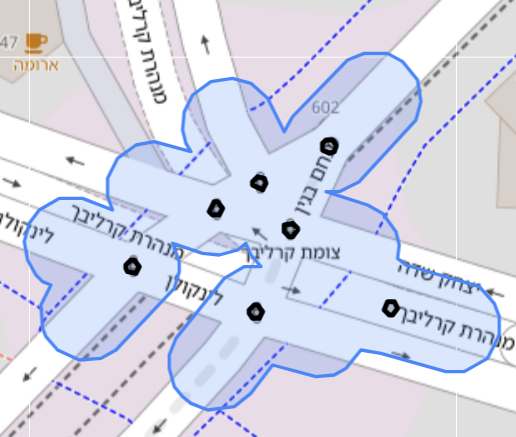
    maybe some accidents will reside in that gap.
    * to handle it, try convex_hull to create a polygon between all residing points
    * make the points of nodes with bigger radius, 5 or more that will cover
      then merge with the crossroad_polygon
2.  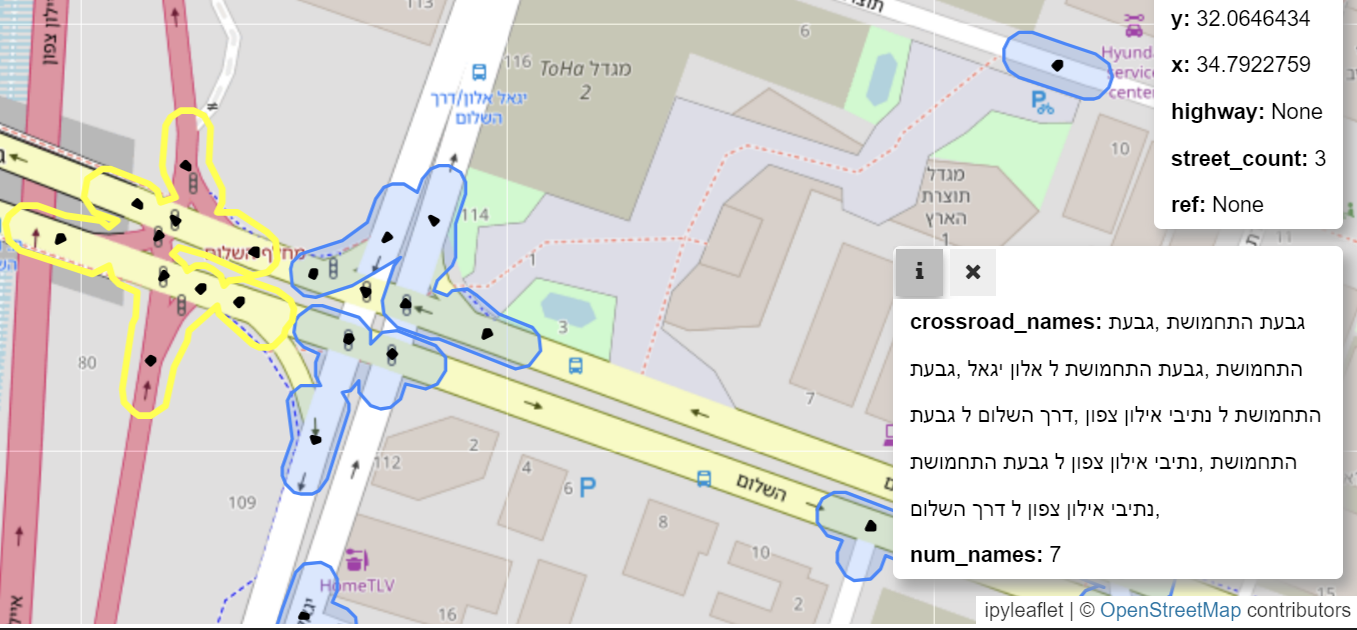
    too many polygons merged some of them belong to roads that are below.
    * create another crossroad_result with smaller buffer and where ever there are a lot of different roads that
      intersect with the smaller poly replace with smaller poly.
      * maybe look at the individual polygons, check the linestring that reside in all of them, if the street names go from one to the other in the area of the polygon that means they all belong to the same road (I hope)
3. 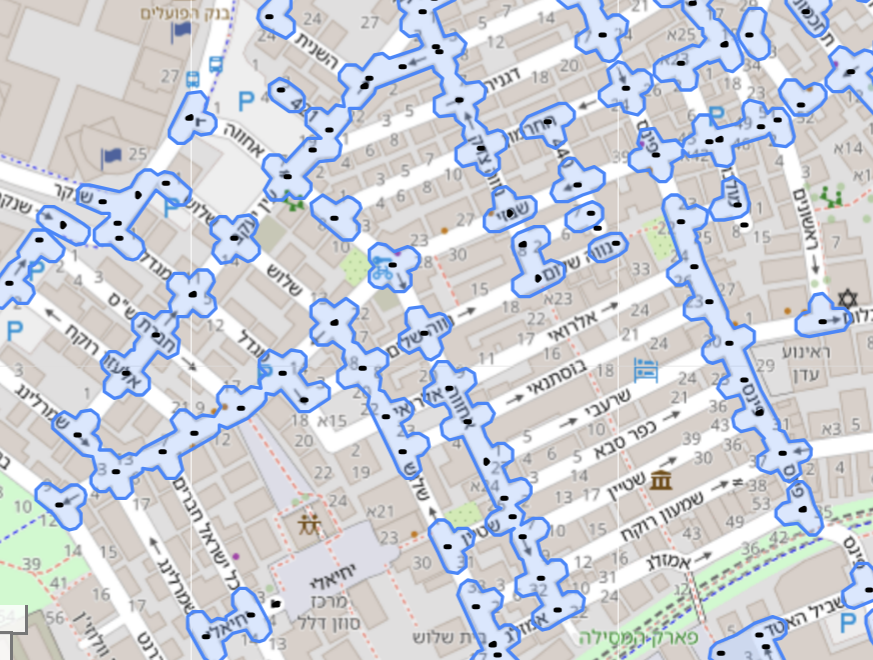
    very small streets that are very close by, merging creates a big blob
    * maybe have a list of these streets and create just for them smaller buffer 

### fixing gaps in large crossroads

1. get the crossroads with large number of street names or large area
2. get the nodes that reside in these crossroads using sjoin
3. preform some gpd grouping so the points will be considered under one geo object
4. preform convex hull
5. check if the result covers the gap and make sure no other issue arises instead
6. merge with the crossroad

#### Is a polygon considered large using area divided by longest line in polygon

Was gonna use this to find polygons with holes, found a better solution.

will keep this, maybe it can help identify problematic polygons such long streets that are connected. 

In [102]:
import geopandas as gpd
from shapely.geometry import Polygon
from scipy.spatial import distance_matrix
import numpy as np

# Function to calculate the longest line using the convex hull
def longest_line_convex_hull(polygon):
    # Step 1: Compute the convex hull
    hull = polygon.convex_hull
    
    # Step 2: Get the coordinates of the convex hull
    coords = np.array(hull.exterior.coords)
    
    # Step 3: Compute pairwise distances
    dist_matrix = distance_matrix(coords, coords)
    
    # Step 4: Find the maximum distance
    max_dist = np.max(dist_matrix)
    return max_dist



crossroads_result["longest_line"] = crossroads_result["geometry"].apply(longest_line_convex_hull)
crossroads_result["area"] = crossroads_result["geometry"].area

In [104]:
crossroads_result['line_area_ratio'] = crossroads_result['area'] / crossroads_result['longest_line']
crossroads_result

geometry  \
0     POLYGON ((665223.903 3545036.282, 665223.357 3...   
1     POLYGON ((665171.756 3545069.916, 665171.756 3...   
2     POLYGON ((665128.378 3545097.692, 665128.326 3...   
3     POLYGON ((665209.001 3545126.908, 665208.452 3...   
4     POLYGON ((665169.522 3545153.636, 665168.109 3...   
...                                                 ...   
4238  POLYGON ((669861.829 3557804.584, 669861.474 3...   
4239  POLYGON ((669581.007 3557709.610, 669580.449 3...   
4240  POLYGON ((669253.728 3557716.719, 669253.092 3...   
4241  POLYGON ((669571.569 3557882.344, 669571.589 3...   
4242  POLYGON ((669629.134 3557684.807, 669629.775 3...   

                                        crossroad_names  num_names  \
0                   הגבול (שמחה הולצברג) ,שדרות ירושלים          2   
1                                  הגבול (שמחה הולצברג)          1   
2                       ברוך קרוא ,הגבול (שמחה הולצברג)          2   
3                                            זלמן מייזל          1   
4                                 ברוך קרוא ,זלמן מייזל          2   
...                                                 ...        ...   
4238  2379 ,‏2379 ל ‏זלצמן פנינה פרופ' ,‏זלצמן פנינה...          3   
4239                                  פרופ' פנינה זלצמן          1   
4240                                      2170 ,יוניצמן          2   
4241                                         2379 ,2425          2   
4242                                  פרופ' פנינה זלצמן          1   

      longest_line        area  line_area_ratio  
0        27.905024  422.298092        15.133407  
1        33.999954  433.690238        12.755612  
2        33.998616  552.009907        16.236247  
3        24.000000  293.690876        12.237120  
4        33.997099  671.108838        19.740179  
...            ...         ...              ...  
4238     33.999991  548.284255        16.126012  
4239     29.014727  415.258476        14.311990  
4240     44.062644  585.691085        13.292236  
4241     33.998351  551.860159        16.231968  
4242     33.997909  467.911330        13.762944  

[4243 rows x 6 columns]

line_area_ratio will help identify large polygons that are long meaning they are connected streets and not actual crossroads.

This is done as such:

longest_line is considered the hypotenuse of a right angled triangle or half a rectangle.<br>
a rectangles of the same circumfuse can have different area, the largest area is when the circumfuse is of a square.

the hypotenuse in a square will be the smallest of these kind of rectangles<br>
so area/longest_line result will increase for crossroads that are closer resemble to a square.

this can help us filter connected streets.

#### Finding polygons with holes and fill the gap

In [144]:
# Add a column to check if polygons have holes
crossroads_result["has_holes"] = crossroads_result["geometry"].apply(lambda poly: len(poly.interiors))

In [147]:
crossroads_result[crossroads_result["has_holes"] > 0].head(5)

geometry  \
53   POLYGON ((664925.922 3545518.925, 664925.521 3...   
85   POLYGON ((665164.680 3545810.700, 665160.179 3...   
89   POLYGON ((666302.274 3545840.192, 666301.597 3...   
144  POLYGON ((665330.694 3546135.982, 665330.441 3...   
208  POLYGON ((666725.132 3546381.142, 666731.967 3...   

                                       crossroad_names  num_names  \
53                                 אפלטון ,אריסטו ,יפת          3   
85   יפת ,נגיב מחפוז ,‏יפת ,‏יפת ל ‏פיקוס ,‏פיקוס ל...          5   
89   הלוחמים ,‏הלוחמים ,‏הלוחמים ל ‏ידין יגאל ,‏ידי...          4   
144                               3175 ,אסף הרופא ,יפת          3   
208                              גרינבוים ,מאיר גרוסמן          2   

     longest_line         area  line_area_ratio  has_holes  
53      73.857772  1780.736251        24.110343          1  
85      65.704381  1501.664510        22.854861          1  
89     106.546598  2268.085295        21.287262          1  
144     52.775772  1257.053003        23.818752          1  
208     59.686793  1892.121714        31.700844          1

In [ ]:
from shapely.geometry import Point, MultiPoint
crossroad_with_holes = crossroads_result[crossroads_result["has_holes"] > 0].copy()
points_in_CR_with_holes = gpd.sjoin(gdf_nodes, crossroad_with_holes, predicate='intersects')
# Group points by polygon (index_right) and aggregate
grouped_points_in_CR_w_h = points_in_CR_with_holes.groupby("index_right")["geometry"].apply(lambda x: MultiPoint(x.tolist()))

# Convert back to GeoDataFrame
grouped_points_CR_w_h = gpd.GeoDataFrame(grouped_points_in_CR_w_h, columns=["geometry"], crs=ta_streets.crs)
grouped_points_CR_w_h = grouped_points_CR_w_h.set_geometry("geometry")
# Ensure grouped_points_CR_w_h is still a GeoDataFrame after operations
grouped_points_CR_w_h['geometry'] = grouped_points_CR_w_h['geometry'].convex_hull
grouped_points_CR_w_h['geometry'] = grouped_points_CR_w_h['geometry'].buffer(5)
grouped_points_CR_w_h

geometry
index_right                                                   
53           POLYGON ((664929.688 3545533.802, 664929.933 3...
85           POLYGON ((665161.546 3545812.551, 665161.034 3...
89           POLYGON ((666310.984 3545844.272, 666310.501 3...
144          POLYGON ((665332.297 3546148.004, 665332.302 3...
208          POLYGON ((666713.651 3546354.011, 666713.248 3...
...                                                        ...
3754         POLYGON ((671519.494 3554965.267, 671519.013 3...
3804         POLYGON ((671905.601 3555080.051, 671905.531 3...
3864         POLYGON ((671576.965 3555215.502, 671576.504 3...
3964         POLYGON ((669614.586 3555402.784, 669614.924 3...
4228         POLYGON ((669681.223 3557571.186, 669681.010 3...

[72 rows x 1 columns]

In [157]:
grouped_points_CR_w_h.columns

Index(['geometry', 'emtpy_col'], dtype='object')

In [162]:
# import leafmap
# m = leafmap.Map(center=(32.047, 34.785), zoom=11)
# # m.add_gdf(crossroads_result.sort_values(by='line_area_ratio').tail(50),fill_colors=['red'])
# m.add_gdf(crossroads_result[crossroads_result["has_holes"] > 0] ,fill_colors=['red'])
# m.add_gdf(grouped_points_CR_w_h)

# m